In [1]:
!pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2

import torch
print(torch.__version__)
major_version, minor_version = torch.cuda.get_device_capability()
# Must install separately since Colab has torch 2.2.1, which breaks packages
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
if major_version >= 8:
    # Use this for new GPUs like Ampere, Hopper GPUs (RTX 30xx, RTX 40xx, A100, H100, L40)
    !pip install --no-deps packaging ninja einops flash-attn "xformers<0.0.26" trl peft accelerate bitsandbytes
else:
    # Use this for older GPUs (V100, Tesla T4, RTX 20xx)
    !pip install --no-deps "xformers<0.0.26" trl peft accelerate bitsandbytes
pass

!pip install evaluate rouge-score

  Using cached torch-2.2.2-cp310-cp310-manylinux1_x86_64.whl (755.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 36.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 41.6 MB/s eta 0:00:00:00:01
  Attempting uninstall: torch
    Found existing installation: torch 2.2.0
    Uninstalling torch-2.2.0:
      Successfully uninstalled torch-2.2.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.17.0
    Uninstalling torchvision-0.17.0:
      Successfully uninstalled torchvision-0.17.0
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.2.0
    Uninstalling torchaudio-2.2.0:
      Successfully uninstalled torchaudio-2.2.0
2.2.2+cu121
  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-26im9s7t/unsloth_d4ec2d5ea72b429497c89be913c19b3a
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-26im9s7t/unsloth_

In [5]:
!pip install wandb

## Import libraries

In [2]:
import os
import numpy as np
import json
import re
from pprint import pprint
import evaluate
import nltk
from nltk.tokenize import (
    sent_tokenize,
    wordpunct_tokenize,
    word_tokenize,
    )
from nltk.corpus import stopwords
import pandas as pd
import torch
from datasets import Dataset, load_dataset
from huggingface_hub import notebook_login
from peft import (
    LoraConfig,
    PeftModel,
    get_peft_model,
)
from transformers import (
    AutoModelForCausalLM,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    MBart50Tokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    QuantoConfig,
    TextStreamer,
)
from unsloth import FastLanguageModel
from torch.utils.data.dataloader import DataLoader
from accelerate import Accelerator
from trl import SFTTrainer
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from tqdm import tqdm
import pandas as pd

2024-05-22 08:03:14.086833: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 08:03:14.230764: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 08:03:14.265490: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-22 08:03:14.935063: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [4]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('italian'))
rouge_score = evaluate.load('rouge')
bleu_score = evaluate.load('bleu')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Setup execution environment

In [3]:
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    device_map = {"": 0}
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100S-PCIE-32GB


In [6]:
import wandb
#wandb.login()
wandb.login(key="2a596940b79889cecb0b70cd92f2fd7f4f3befa3")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: martinaianaro-tesi (pictobert). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/anna.vitali7/.netrc


True

## Functions


In [7]:
SOURCE_NAME = 'source'
TARGET_NAME = 'target'
INSTRUCTION = "Riassumi il seguente articolo"

### Utilities

In [8]:
def generate_text(data_point):
    summary = data_point[SOURCE_NAME]
    text = ""
    for item in data_point[TARGET_NAME]:
        text_clean = clean_text(item)
        text += text_clean.strip()

def flatten(nested_list):
    return [' '.join(sublist) for sublist in nested_list]

def combine_texts(source, target):
    return {
    "text": f"""
    {INSTRUCTION}

    ### Sorgente
    {source}

    ### Sommario
    {target}
    """}



### Text Cleaning

In [9]:
def remove_symbols(text):
    result = wordpunct_tokenize(text)
    remove_element = '!"$\'%(),.:;?l[]{}@€#<>*+-=/_'
    filtered_result = [word.lower() for word in result if word not in remove_element]
    return ' '.join(filtered_result)

def replace_newline(text):
    return text.replace('\n', ' ')

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def remove_non_alphanumeric(text):
    return ''.join([i for i in text if i.isalpha() or i.isspace()])

def lowercase(text):
    return text.lower()

def remove_emojis(text):
    emoji_pattern = re.compile("[" u"\U0001F600-\U0001F64F"  # emoticoni generici
                               u"\U0001F300-\U0001F5FF"  # simboli & pictogrammi
                               u"\U0001F680-\U0001F6FF"  # simboli del trasporto & mappe
                               u"\U0001F1E0-\U0001F1FF"  # bandiere (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_text(text):
    text = remove_symbols(text)
    text = replace_newline(text)
    text = remove_stopwords(text)
    text = remove_non_alphanumeric(text)
    text = lowercase(text)
    text = remove_emojis(text)
    return text

def dataset_clean(data: Dataset):
    def preprocess_example(example):
        example[SOURCE_NAME] = clean_text(example[SOURCE_NAME])
        example[TARGET_NAME] = clean_text(example[TARGET_NAME])
        return example

    return (
        data.shuffle(seed=42)
            .map(preprocess_example)
            .map(generate_text)
            #.remove_columns(
            #  [
            #    "url",
            #    "title",
            #    "materia",
            # ]
        )
    #)

### Tokenization

In [10]:
def preprocess_function(examples, tokenizer, max_source_length, max_target_length):
    # Flatten the documents if necessary
    if isinstance(examples[SOURCE_NAME][0], list):
        docs = flatten(examples[SOURCE_NAME])
    else:
        docs = examples[SOURCE_NAME]
    inputs = [doc for doc in docs]
    model_inputs = tokenizer(inputs, truncation=True, padding=True, return_tensors="pt")

    # Flatten the summaries if necessary
    if isinstance(examples[TARGET_NAME][0], list):
        summaries = flatten(examples[TARGET_NAME])
    else:
        summaries = examples[TARGET_NAME]
    labels = tokenizer(summaries, truncation=True, padding=True, return_tensors="pt")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

    # Flatten the summaries if necessary
    summaries = flatten(examples[TARGET_NAME])
    labels = tokenizer(summaries, truncation=True, padding=True, return_tensors="pt")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

### Metrics

In [11]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    result_rouge = rouge_score.compute(
      predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )

    result_bleu = bleu_score.compute(
      predictions=decoded_preds, references=decoded_labels
    )

    result_rouge = {key: value for key, value in result_rouge.items()}
    result_rouge = {k: round(v, 4) for k, v in result_rouge.items()}
    return {"rouge": result_rouge, "bleu": result_bleu}

def compute_metrics_test(predictions, references):
    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")
    meteor = evaluate.load('meteor')


    rouge_results= rouge.compute(predictions=predictions, references=references)
    bleu_results = bleu.compute(predictions=predictions, references=references)
    meteor_results = meteor.compute(predictions=predictions, references=references)

    return rouge_results, bleu_results, meteor_results

## Fine-tuning

In [12]:
base_model = "unsloth/llama-3-8b-bnb-4bit"
dataset_name = "ARTeLab/fanpage"
base_path="./"

output_dir = f"{base_path}/{base_model}.finetuned.{dataset_name}"

new_model = f"{base_model}.finetuned.{dataset_name}"

### Dataset

In [13]:
dataset = load_dataset(dataset_name)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['source', 'target'],
        num_rows: 67492
    })
    validation: Dataset({
        features: ['source', 'target'],
        num_rows: 8436
    })
    test: Dataset({
        features: ['source', 'target'],
        num_rows: 8437
    })
})


In [14]:
dataset_train = dataset['train']
dataset_validation = dataset['validation']

### Lenght of the news before cleaning

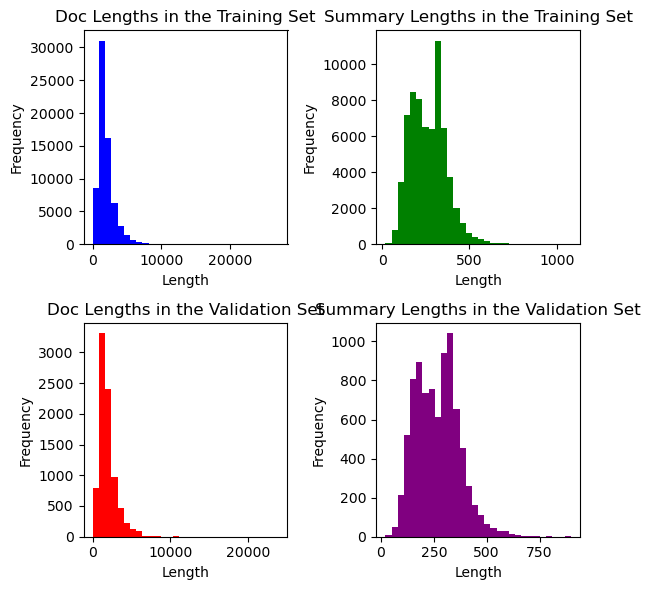

In [15]:
# Calculate the lengths of the phrases in the training and validation sets
train_lengths_doc = [len(item['source']) for item in dataset['train']]
train_lengths_summary = [len(item['target']) for item in dataset['train']]
validation_lengths_doc = [len(item['source']) for item in dataset['validation']]
validation_lengths_summary = [len(item['target']) for item in dataset['validation']]

# Create a histogram for each set
plt.figure(figsize=(6, 6))

plt.subplot(2, 2, 1)
plt.hist(train_lengths_doc, bins=30, color='blue')
plt.title('Doc Lengths in the Training Set')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(train_lengths_summary, bins=30, color='green')
plt.title('Summary Lengths in the Training Set')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(validation_lengths_doc, bins=30, color='red')
plt.title('Doc Lengths in the Validation Set')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(validation_lengths_summary, bins=30, color='purple')
plt.title('Summary Lengths in the Validation Set')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Dataset cleaning

In [16]:
dataset_train_clean = dataset_clean(dataset_train)
dataset_validation_clean = dataset_clean(dataset_validation)

Map:   0%|          | 0/67492 [00:00<?, ? examples/s]

Map:   0%|          | 0/8436 [00:00<?, ? examples/s]

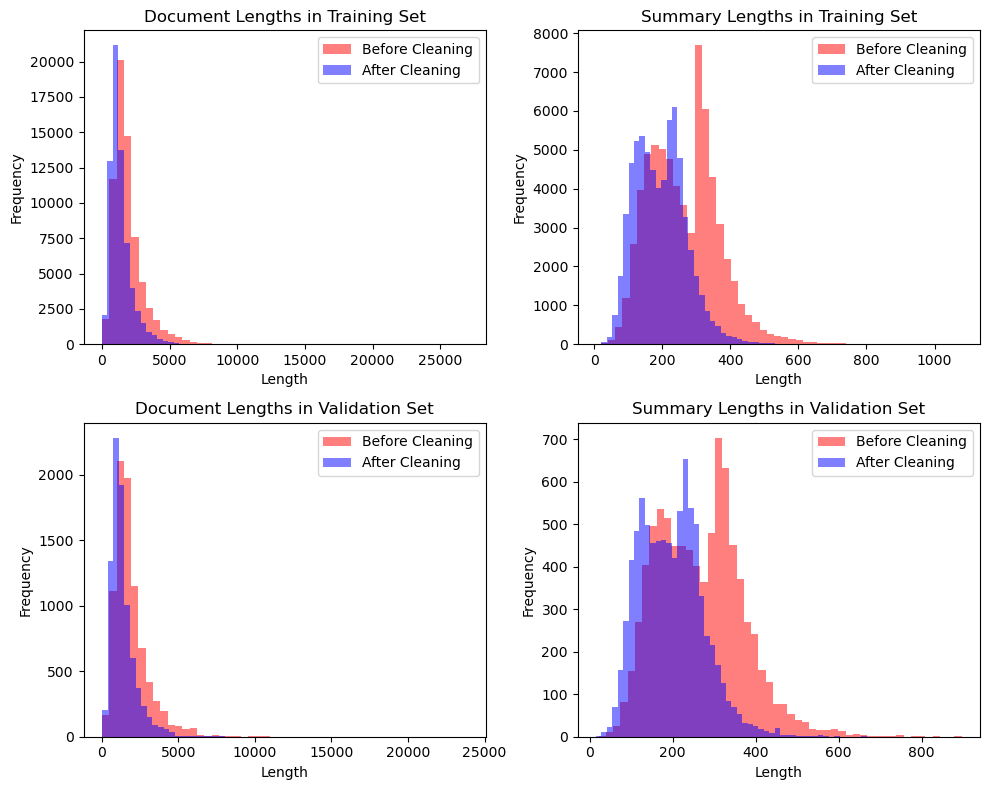

In [17]:
train_lengths_doc_before_cleaning = [len(item[SOURCE_NAME]) for item in dataset_train]
train_lengths_summary_before_cleaning = [len(item[TARGET_NAME]) for item in dataset_train]
validation_lengths_doc_before_cleaning = [len(item[SOURCE_NAME]) for item in dataset_validation]
validation_lengths_summary_before_cleaning = [len(item[TARGET_NAME]) for item in dataset_validation]

cleaned_train_lengths_doc = [len(item[SOURCE_NAME]) for item in dataset_train_clean]
cleaned_train_lengths_summary = [len(item[TARGET_NAME]) for item in dataset_train_clean]
cleaned_validation_lengths_doc = [len(item[SOURCE_NAME]) for item in dataset_validation_clean]
cleaned_validation_lengths_summary = [len(item[TARGET_NAME]) for item in dataset_validation_clean]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Grafico per il dataset di addestramento
axs[0, 0].hist(train_lengths_doc_before_cleaning, color='red', alpha=0.5, bins=50, label='Before Cleaning')
axs[0, 0].hist(cleaned_train_lengths_doc, color='blue', alpha=0.5, bins=50, label='After Cleaning')
axs[0, 0].set_title('Document Lengths in Training Set')
axs[0, 0].set_xlabel('Length')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].legend()

axs[0, 1].hist(train_lengths_summary_before_cleaning, color='red', alpha=0.5, bins=50, label='Before Cleaning')
axs[0, 1].hist(cleaned_train_lengths_summary, color='blue', alpha=0.5, bins=50, label='After Cleaning')
axs[0, 1].set_title('Summary Lengths in Training Set')
axs[0, 1].set_xlabel('Length')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].legend()

# Grafico per il dataset di validazione
axs[1, 0].hist(validation_lengths_doc_before_cleaning, color='red', alpha=0.5, bins=50, label='Before Cleaning')
axs[1, 0].hist(cleaned_validation_lengths_doc, color='blue', alpha=0.5, bins=50, label='After Cleaning')
axs[1, 0].set_title('Document Lengths in Validation Set')
axs[1, 0].set_xlabel('Length')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].legend()

axs[1, 1].hist(validation_lengths_summary_before_cleaning, color='red', alpha=0.5, bins=50, label='Before Cleaning')
axs[1, 1].hist(cleaned_validation_lengths_summary, color='blue', alpha=0.5, bins=50, label='After Cleaning')
axs[1, 1].set_title('Summary Lengths in Validation Set')
axs[1, 1].set_xlabel('Length')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

In [18]:
max_length_doc_before_cleaning = max(train_lengths_doc_before_cleaning)
max_length_summary_before_cleaning = max(train_lengths_summary_before_cleaning)

max_length_doc_after_cleaning = max(cleaned_train_lengths_doc)
max_length_summary_after_cleaning = max(cleaned_train_lengths_summary)

print("Max length before cleaning for the training dataset:")
print(f"Max length of the text: {max_length_doc_before_cleaning}")
print(f"Max length of the summary: {max_length_summary_before_cleaning}")

print("Max length after cleaning for the training dataset:")
print(f"Max length of the text: {max_length_doc_after_cleaning}")
print(f"Max length of the summary: {max_length_summary_after_cleaning}")

max_length_doc_before_cleaning_val = max(validation_lengths_doc_before_cleaning)
max_length_summary_before_cleaning_val = max(validation_lengths_summary_before_cleaning)

max_length_doc_after_cleaning_val = max(cleaned_validation_lengths_doc)
max_length_summary_after_cleaning_val = max(cleaned_validation_lengths_summary)

print("\nMax length before cleaning for the validation dataset:")
print(f"Max length of the text: {max_length_doc_before_cleaning_val}")
print(f"Max length of the summary: {max_length_summary_before_cleaning_val}")

print("Max length after cleaning for the validation dataset:")
print(f"Max length of the text: {max_length_doc_after_cleaning_val}")
print(f"Max length of the summary: {max_length_summary_after_cleaning_val}")

Max length before cleaning for the training dataset:
Max length of the text: 27019
Max length of the summary: 1080
Max length after cleaning for the training dataset:
Max length of the text: 20377
Max length of the summary: 802

Max length before cleaning for the validation dataset:
Max length of the text: 23893
Max length of the summary: 897
Max length after cleaning for the validation dataset:
Max length of the text: 18344
Max length of the summary: 668


In [19]:
original_train_lengths_source = [len(item[SOURCE_NAME]) for item in dataset_train]
original_train_lengths_target = [len(item[TARGET_NAME]) for item in dataset_train]

cleaned_train_lengths_source = [len(item[SOURCE_NAME]) for item in dataset_train_clean]
cleaned_train_lengths_target = [len(item[TARGET_NAME]) for item in dataset_train_clean]

mean_original_length_source = sum(original_train_lengths_source) / len(original_train_lengths_source)
mean_cleaned_length_source = sum(cleaned_train_lengths_source) / len(cleaned_train_lengths_source)

mean_original_length_target = sum(original_train_lengths_target) / len(original_train_lengths_target)
mean_cleaned_length_target = sum(cleaned_train_lengths_target) / len(cleaned_train_lengths_target)

reduction_percentage_source = ((mean_original_length_source - mean_cleaned_length_source) / mean_original_length_source) * 100
reduction_percentage_target = ((mean_original_length_target - mean_cleaned_length_target) / mean_original_length_target) * 100

print("Percentuale media di riduzione della lunghezza per 'source':", reduction_percentage_source)
print("Percentuale media di riduzione della lunghezza per 'target':", reduction_percentage_target)

Percentuale media di riduzione della lunghezza per 'source': 27.66236781227694
Percentuale media di riduzione della lunghezza per 'target': 26.42877213987569


### Preparing the data

In [20]:
combined_texts_train = [combine_texts(source, target) for source, target in zip(dataset_train_clean[SOURCE_NAME], dataset_train_clean[TARGET_NAME])]
finetuning_train_dataset = Dataset.from_dict({"text": [ct["text"] for ct in combined_texts_train]})

combined_texts_train = [combine_texts(source, target) for source, target in zip(dataset_validation_clean[SOURCE_NAME], dataset_validation_clean[TARGET_NAME])]
finetuning_validation_dataset = Dataset.from_dict({"text": [ct["text"] for ct in combined_texts_train]})

In [21]:
finetuning_train_dataset = finetuning_train_dataset.select(range(1000))
finetuning_validation_dataset= finetuning_validation_dataset.select(range(500))

### Tokenization

In [22]:
tokenizer = AutoTokenizer.from_pretrained(base_model)
print(f'Vocabulary size: {tokenizer.vocab_size}')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Vocabulary size: 128000


In [23]:
max_source_length = 1024
max_target_length = 512
tokenized_train_dataset = dataset_train_clean.map(
    preprocess_function,
    fn_kwargs={
        "tokenizer": tokenizer,
        "max_source_length": max_source_length,
        "max_target_length": max_target_length
    },
    batched=True,
    remove_columns=["source", "target"]
)

tokenized_valid_dataset = dataset_validation_clean.map(
    preprocess_function,
    fn_kwargs={
        "tokenizer": tokenizer,
        "max_source_length": max_source_length,
        "max_target_length": max_target_length
    },
    batched=True,
    remove_columns=[SOURCE_NAME, TARGET_NAME]
)

In [24]:
max_token_length = max(len(tokens) for tokens in tokenized_train_dataset['input_ids'])
print(f"Maximum token length in the training dataset: {max_token_length}")
max_token_length = max(len(tokens) for tokens in tokenized_valid_dataset['input_ids'])
print(f"Maximum token length in the validation dataset: {max_token_length}")

Maximum token length in the training dataset: 5105
Maximum token length in the validation dataset: 4368


### Training

In [25]:
max_seq_length =  6000 #16384
model, tokenizer = FastLanguageModel.from_pretrained(
  base_model,
  max_seq_length = max_seq_length,
  dtype = None,
  load_in_4bit = True,
  device_map=device_map
)

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: Tesla V100S-PCIE-32GB. Max memory: 31.739 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.2+cu121. CUDA = 7.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [26]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [27]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla V100S-PCIE-32GB. Max memory = 31.739 GB.
5.605 GB of memory reserved.


In [28]:
trainer2 = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = finetuning_train_dataset,
    eval_dataset = finetuning_validation_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = output_dir,
    ),
)

Map (num_proc=2):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/500 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [29]:
wandb.init(
    project="Llama3-train-V100",
    config={
        "learning_rate": 2e-4,
        "architecture": "Llama3",
        "dataset": "fanpage",
    }
)

In [30]:
trainer_stats = trainer2.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss
1,3.298900
2,3.494200
3,3.461400
4,3.060800
5,3.043900
6,3.217900
7,2.984600
8,3.143600
9,3.062000
10,3.243300


In [31]:
model.save_pretrained(output_dir)

## Prediction on test set

In [35]:
dataset_test = dataset['test'].select(range(100))
dataset_test_clean = dataset_clean(dataset_test)
combined_texts_test = [combine_texts(source, target) for source, target in zip(dataset_test_clean[SOURCE_NAME], dataset_test_clean[TARGET_NAME])]
finetuning_test_dataset = Dataset.from_dict({"text": [ct["text"] for ct in combined_texts_test]})

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [37]:
llama_prompt="""Riassumi il seguente articolo

### Sorgente
{}

### Sommario
{}
"""

FastLanguageModel.for_inference(model)
text_streamer = TextStreamer(tokenizer)

rouge_scores = []
bleu_scores = []
meteor_scores = []

for i in tqdm(range(len(finetuning_test_dataset))):
    # input preparation
    inputs = tokenizer(
        [
            llama_prompt.format(
                dataset_test[i][SOURCE_NAME],  # input
                "",
            )
        ],
        return_tensors="pt"
    ).to("cuda")

    result = model.generate(**inputs, streamer=text_streamer, max_new_tokens=1000)
    prediction = tokenizer.decode(result[0], skip_special_tokens=True)

    # Calcola e memorizza le metriche per la previsione
    references = [dataset_test[i][TARGET_NAME]] 
    rouge_results, bleu_results, meteor_results = compute_metrics_test([prediction], references)
    rouge_scores.append(rouge_results)
    bleu_scores.append(bleu_results)
    meteor_scores.append(meteor_results)

  0%|          | 0/100 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
"Come ogni opera d'arte raffinata, Bowlus è il risultato di un design spettacolare e di un'artigianato meticoloso. Non c'è niente al mondo come un'avventura Bowlus. Romanzi epici di viaggi su strada come Travels with Charley di John Steinbeck, On the Road di Jack Kerouac e Blue Highways di William Least Heat-Moon ci lasciano sempre desiderosi di quelle piccole strade e terre pubbliche dimenticate che collegano e intrecciare le nostre narrazioni di viaggio insieme. La nostra ispirazione per il campeggio fuori dalla rete nasce dal desiderio di avventurarci nell'ignoto.", racconta Geneva Long, CEO di Bowlus Road Chief, l'azienda a conduzione familiare di designer, ambientalisti e perfezionisti che ha riportato in auge l'iconico Bowlus, il camper di alluminio ideato quasi 90 anni fa dal designer, ingegnere e costruttore di aerei Hawley Bowlus e che ha ispirato anche il famoso Airstream. Bowlus oggi rappresenta il rimorchio da via

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
  1%|          | 1/100 [00:22<36:56, 22.39s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
I cosiddetti “Big Data” rappresentano una risorsa preziosissima da analizzare ed estrapolare, sia per condurre indagini statistiche che in ottica predittiva. Basti pensare all'algoritmo messo a punto nei mesi scorsi da scienziati americani dell'Università Johns Hopkins, in grado di prevedere i focolai di COVID-19 con 2-3 settimane di anticipo, analizzando i contenuti dei “cinguettii” degli utenti di Twitter e le notizie su Google. Una mole enorme di dati (i Big Data, appunto) da dare in pasto a un'intelligenza artificiale avanzata. Il Pentagono, ovvero il Dipartimento della Difesa degli Stati Uniti, ha appena annunciato che sta testando un sofisticatissima IA che ha l'obiettivo di prevedere con “giorni di anticipo” eventi di grande rilevanza nazionale e internazionale, analizzando dati da molteplici fonti. Sebbene siamo ancora lontani dalla fantascienza alla base del blockbuster hollywoodiano Minority Report, nel quale veniva

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
  2%|▏         | 2/100 [01:25<1:15:16, 46.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Continuano ad aumentare i nuovi casi di coronavirus nel nostro Paese. Sono stati 2.800 i contagi registrati ieri: numeri che preoccupano il governo e che ricordano quelli delle fasi più critiche dell'emergenza. Domani l'esecutivo si riunirà e valuterà se sia il caso di rendere più severe le norme anti-contagio attualmente in vigore. Entro la prossima settimana si attende il nuovo Dpcm contenente le misure di contrasto all'epidemia, mentre si valuta la proroga dello stato di emergenza fino al prossimo 31 gennaio 2021. Ma vediamo quindi quali sono queste nuove regole che il governo sta pensando di introdurre per frenare la curva dei contagi. L'obbligo di portare la mascherina all'aperto, già introdotto nei giorni scorsi in alcune zone, sarà esteso a tutto il territorio nazionale. Oltre quindi a confermare la necessità di indossare sempre il dispositivo di protezione nei luoghi chiusi, di igienizzare frequentemente le mani e di 

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
  3%|▎         | 3/100 [02:34<1:31:23, 56.53s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Jenna Thompson, 33 anni, è mamma di Emilia da quattordici mesi. Il suo parto è stato un’esperienza traumatica: ha perso tre litri di sangue ed ha subito gravi danni interni, tanto che i medici le avevano proibito di praticare il suo sport preferito, il body building. Jenna, però, non si è arresa e, dopo quattro mesi di fisioterapia, ha voluto ricominciare a fare sport. Ha lentamente riacquistato la forza muscolare ed oggi è di nuovo in grado di sollevare i pesi senza problemi.

### Sommario

Jenna Thompson, 33 anni, dopo aver partorito Emilia da quattordici mesi, dopo aver subito gravi danni interni, riacquisisce la forza muscolare grazie all’allenamento

### Sommario

Jenna Thompson, 33 anni, dopo aver partorito Emilia da quattordici mesi, dopo aver subito gravi danni interni, riacquisisce la forza muscolare grazie all’allenamento

### Sommario

Jenna Thompson, 33 anni, dopo aver partorito Emilia da quattordici mesi, dopo av

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
  4%|▍         | 4/100 [03:30<1:30:36, 56.63s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Chris Wedge, premio Oscar per il cortometraggio d’animazione “Bunny” nel 1999 e regista de “L’Era Glaciale” e “Rio”, sta per approdare nelle sale con un film d’animazione della Blue Sky Studios che racconta la fantastica avventura di una giovane ragazza alle prese con il mondo sconosciuto della flora che ci circonda. Un viaggio epico, con un cast di doppiatori originali da brivido. Il pubblico italiano potrà ammirare questo gioiellino d’animazione a partire dal 23 maggio. Mary Katherine, una giovane ragazza, si risveglia un giorno e scopre di non essere più a casa sua, ma di essere stata trasportata in un altro universo. Qui si unirà ad alcuni personaggi appena incontrati che cercano di sopravvivere all'attacco continuo da parte dei loro nemici. La ragazza scoprirà poi che in realtà non si trova in un altro universo, ma semplicemente in una foresta della Terra, e che è stata in qualche modo rimpicciolita. Capirà quindi che la

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
  5%|▌         | 5/100 [04:01<1:14:34, 47.10s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
La risposta definitiva a chi pensa che il cast, gli attori, non fanno il cinema. Per rilanciare la serie di Indiana Jones nell’89, George Lucas e Menno Meyjes (regista di Manolete con Penelope Cruz) tirano fuori l'idea del padre sparito e ritrovato che farebbe molto soap-opera se non fosse per l'attore chiamato a coprire il ruolo di Henry Jones: Sean Connery, la più grande icona avventurosa di sempre. James Bond accanto a Indiana Jones. Ne esce fuori il più divertente episodio della serie, in cui l'intreccio tra avventura, storia, mistero e commedia raggiunge vette di perfezione. Indy, parte ovviamente alla ricerca del padre, ma non sa che c'è qualcos' altro di molto più grandioso da cercare: il Sacro Graal, sulle cui tracce si sono messi anche i nazisti. E il rapporto tra Harrison Ford (coinvolto nel progetto del quinto film della serie sul Triangolo delle Bermude) e Connery dà il pepe, il ritmo, il sorriso a un film sperico

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
  6%|▌         | 6/100 [05:07<1:24:22, 53.85s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Brandon Lincoln, un giovane di 31 anni, è stato ucciso per strada, attirato nella trappola del suo killer nel Midtown di New York. Il ragazzo pare sia stato sottoposto a una vera e propria esecuzione, secondo quanto riporta anche il Wall Street Journal. L'omicidio ha avuto luogo tra West Street e la 58esima: l'assassino si è avvicinato alla vittima, quasi volesse sbirciare il cellulare del 31enne, per poi ucciderlo con un colpo di pistola a bruciapelo. Dal canto suo, la polizia newyorchese il ragazzo è stato attirato in una trappola e portato sul luogo con l'inganno.

### Sommario

Brandon Lincoln, un giovane di 31 anni, è stato ucciso per strada, attirato nella trappola del suo killer nel Midtown di New York. L'omicidio avvenuto tra West Street e la 58esima: l'assassino si avvicinato alla vittima, quasi volesse sbirciare il cellulare del 31enne, per poi ucciderlo con un colpo di pistola a bruciapelo. Dal canto sua, la polizi

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
  7%|▋         | 7/100 [06:20<1:32:58, 59.98s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Chadia Rodriguez, la rapper di origine spagnola e marocchina, rientra tra i 53 indagati accusati di furti e rapine messe a tiro in varie zone d'Italia e d'Europa e conosciuti per l'utilizzo dello spray al peperoncino. L'episodio nel quale sarebbe coinvolta risale al settembre 2017 e la giovane cantante sarebbe accusata di aver adescato l'uomo che poi sarebbe diventato la vittima del furto. L'8 settembre 2017 durante una rapina ai danni un uomo nel torinese, sarebbe stata presente anche la giovane cantante. Secondo la ricostruzione degli atti del processo in cui Zaccaria El Fadili è stato accusato per aver utilizzato un'arma come lo spray al peperoncino e per il quale è arrivato a patteggiare per una reclusione di tre anni e tre mesi, Chadia Rodriguez avrebbe avuto un ruolo fondamentale, quello di attirare la vittima a da lei e i suoi complici. Come raccontato dall'uomo vittima del furto, costui aveva conosciuto la giovane e a

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
  8%|▊         | 8/100 [07:04<1:24:00, 54.79s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Non lo vuole sposare. E’ quanto emerge all’interno dell’ultima intervista di Raffaella Fico che, ringraziando Mancini per i buoni consigli elargiti al suo fidanzato, rimanda l’idea del matrimonio per qualche anno ancora. La soubrette, che è stata recentemente protagonista di una dedica di Supermario, non ha ancora intenzione di accasarsi perché è sicura che per mettersi la fede al dito ci sia ancora tempo. Nonostante il suo Mario sia uno degli sportivi più desiderati al mondo, l’ex protagonista del Grande Fratello non ha alcuna intenzione di cedere seriamente alla sua corte. Solo qualche giorno fa, infatti, dopo l’ultima bravata di Balotelli, Mancini gli aveva consigliato di sposare la sua Raffaella e di mettere la testa a posto. Chi pensava che sarebbe stato Mario a rispondere, però, si è sbagliato. A mettere le cose bene in chiaro è la Fico che, intervistata dall’emittente radiofonica Rtl 102.5, dice: È presto per sposarsi,

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
  9%|▉         | 9/100 [08:16<1:31:18, 60.20s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
"Tran tran" era nato per essere solo un singolo, pare, finché Sfera Ebbasta, sommerso dal successo del pezzo, ha deciso di legittimarlo e dargli spazio anche nel suo nuovo "Rockstar", il suo terzo album ufficiale, dopo "XDVR" del 2015 e quello omonimo del 2016. Gionata Boschetti da Cinisello Balsamo è probabilmente uno dei personaggi più influenti del genere e in coppia con un altro enfant prodige come Charlie Charles ha optato per un album molto variegato che, però, è meno cupo del precedente e gioca sull'alternanza tra pezzi più "catchy" e altri più scuri, come dimostra subito l'accoppiata "Rockstar", singolo e forse uno dei più "radiofonici" del mazzo e la successiva "Serpenti a sonagli". Dopo il "King del rap" Marracash, Sfera poteva puntare a un "Trapstar", ma ha preferito non limitarsi al genere e optare per un più universale "Rockstar": "Avevamo pensato che avrebbe potuto chiamarsi anche ‘Trapstar', ma ci sembrava trop

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 10%|█         | 10/100 [09:20<1:31:55, 61.29s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Diramato il bollettino Covid di mercoledì 29 settembre 2021 relativo alla Lombardia. Dal ministero della Salute informano che nelle ultime 24 ore sono stati 438 i nuovi casi su 54.880 tamponi eseguiti. Si registrano 5 ulteriori vittime: ieri erano state 6. Da febbraio dello scorso anno i decessi ufficiali per Covid in Lombardia sono adesso arrivati a 34.037. I contagi sono aumentati rispetto a ieri, quando erano stati registrati 345 nuovi casi di Coronavirus a fronte di 63.638 tamponi eseguiti. Ecco la situazione negli ospedali lombardi: nei reparti di area medica, non critica, sono ricoverati 384 pazienti Covid, in diminuzione (-9) rispetto a ieri quando erano 393. Nelle terapie intensive degli ospedali lombardi invece sono ricoverati 58 degenti Covid, 2 in più rispetto a 24 ore fa quando se ne contavano 56.

### Sommario

### Sorgente
Diramato il bollettino Covid di mercoledì 29 settembre 2021 relativo alla Lombardia. Dal m

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 11%|█         | 11/100 [09:42<1:13:15, 49.39s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Un bambino di 3 anni è deceduto dopo essere caduto dal terzo piano di un edificio in via Foria, nel centro di Napoli, nelle vicinanze della ex caserma Garibaldi, sede dell'Ufficio del Giudice di Pace. La tragedia è avvenuta nella tarda mattinata di oggi, 17 settembre, poco prima delle 13. La Procura ha aperto una inchiesta, la salma del piccolo è stata sequestrata e verrà svolta nei prossimi giorni l'autopsia; la dinamica è in fase di ricostruzione. Sul posto è intervenuta la Polizia di Stato per i rilievi e l'avvio delle indagini. Il piccolo, a quanto si apprende, è precipitato dalla sua abitazione, non è ancora accertato se da una finestra o da un balcone, in un palazzo all'angolo tra via Foria e una delle traverse, via Giuseppe Piazzi, una zona molto popolosa. Pare che al momento della caduta si trovasse da solo in casa con la madre, sarebbe sfuggito al controllo mentre la donna era in un'altra stanza e si sarebbe sporto, 

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 12%|█▏        | 12/100 [10:47<1:19:25, 54.15s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
All'inizio del 2019 Lufthansa ha ritirato il suo Airbus a340-600 D-AIHO e anziché mandarlo allo scasso ha invitato un gruppo di designer e creativi per realizzare una linea di design con le vecchie parti dell'aereo dismesso. Dai tavoli fatti con pezzi delle ali dell'Airbus ai finestrini dell'aereo diventati espositori per bottiglie o altri oggetti, il riciclo creativo dell'aeroplano Lufthansa dovrebbe essere un esempio per tutte le aziende perché evitare gli sprechi e impegnarsi a favore dell'ambiente si può. Upcycling Collection è la collezione di mobili e oggetti per la casa fatta Lufthansa da con vecchie parti di aeroplani. La linea di arredi e oggetti per la casa comprende dei tavoli da caffè, una scrivania, degli espositori, delle poltrone, zaini, portafogli e borse, tutto realizzato dal riciclo delle vecchie parti dell'Airbus a340-600 D-AIHO: "Le cabine Lufthansa sono piene di materiali di alta qualità. anche la pelle e

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 13%|█▎        | 13/100 [11:35<1:16:00, 52.42s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
A tre giorni di distanza dall'inizio dei preordini dei nuovi iPhone 8 e 8 Plus, sul sito di Apple le cose stanno andando diversamente rispetto agli anni passati. Se con i lanci precedenti le tempistiche per le consegne si spostavano in pochi minuti ad oltre un mese dopo l'acquisto, questa volta le cose sono andate in altro modo. Per tutta la giornata di venerdì, quando si sono aperti i preordini a livello globale, i nuovi iPhone sono rimasti disponibili con consegna prevista per il 22 settembre, data di lancio. Oggi, dopo un intero weekend, la consegna è prevista in 1 o 2 settimane, cioè massimo 7 giorni dopo la data di lancio. Perché? Le motivazioni possono essere due: da un lato un improbabile flop di Apple con il nuovo telefono, considerato troppo simile al modello dello scorso anno e poco appetibile per l'utenza. È improbabile perché pur essendo una versione "di passaggio" simile ai modelli "S" degli scorsi anni, l'iPhone

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 14%|█▍        | 14/100 [12:37<1:19:00, 55.12s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Le voci su un nuovo arrivo in casa Ferragnez si fanno sempre più insistenti. Secondo fonti vicine a Fanpage.it, Chiara Ferragni è incinta e il suo annuncio sarebbe prossimo. Al momento non ci sono dettagli in grado di dare sostanza a un'indiscrezione di cui, tuttavia, si vocifera da giorni. L'imprenditrice e fashion blogger, sposata con Fedez dal 2018 e certamente tra i personaggi italiani più influenti al mondo in questo momento storico, ha messo al mondo nello stesso anno il suo primo figlio Leone, quotidianamente presente nei racconti familiari dei due genitori attraverso i social, che però non utilizzano solo ed esclusivamente per raccontarsi ai fan giornalmente. Da tempo, ormai, sui profili della nota influencer e in particolare attraverso Instagram, non appaiono più solo look con abiti griffati. In diverse occasioni, infatti, Ferragni ha detto la sua su tematiche di attualità di grande peso ha mandato, contribuendo alla

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 15%|█▌        | 15/100 [13:02<1:05:09, 45.99s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Meghan Markle e il principe Harry hanno invaso le pagine dei giornali negli ultimi giorni con il loro "divorzio" dai Royals. Sebbene per alcuni sembri assurdo rinunciare a titoli e privilegi reali, i Duchi del Sussex hanno portato avanti con determinazione questa "battaglia", a dimostrazione del fatto che la libertà e l'indipendenza dalle rigide regole dell'etichetta sono due cose che non hanno prezzo. L'ex attrice si è ormai trasferita in Canada da diverse settimane, solo di recente l'ha raggiunta anche Harry, e a quanto pare ha rivoluzionato il suo stile, dicendo addio agli abiti da principessa e passando a qualcosa di più casual come gli scarponcini da trekking.

### Sommario

Meghan Markle e il principe Harry hanno invaso le pagine dei giornali negli ultimi giorni con il loro "divorzio" dai Royals. Sebbene per alcuni sembri assurdo rinunciare a titoli e privilegi reali, i Duchi del Sussex hanno portato avanti con determin

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 16%|█▌        | 16/100 [14:04<1:11:21, 50.97s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Tra i film che dovevano arrivare nelle sale cinematografiche in questi mesi e hanno poi posticipato la loro data d'uscita, vi era anche Wonder Woman 1984, il sequel del noto film con protagonista Gal Gadot che sarebbe dovuto approdare sul grande schermo a partire da questa estate. La Warner Bros ha recentemente annunciato che per non rimandare ulteriormente l'arrivo del film, potremo vederlo tutti sulla piattaforma streaming di HBO, ma stando alle ultime notizie, pare che la grande casa di produzione cinematografica abbia deciso di distribuire la pellicola anche nelle sale europee e non solo in quelle americane, come inizialmente previsto. Stando a quanto dichiarato dalla Warner Bros, quindi, Wonder Woman 1984 seguirà un calendario ben preciso di uscite, a partire dal 16 dicembre, data in cui apparirà sul grande schermo di molti paesi del mondo, compresi Francia e Regno Unito. In America, come già annunciato, sia nelle sale c

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 17%|█▋        | 17/100 [15:01<1:13:05, 52.83s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Introdotto dal decreto Covid del 22 aprile, il green pass (chiamato anche certificazione verde), è un certificato che permette di viaggiare sul territorio nazionale anche dall'estero. Tale certificazione, disponibile dalla metà di giugno, sarà poi sostituita dall'Eu Digital Certificate Covid-19, un documento ideato dalla Commissione europea per permettere di viaggiare tra i paesi dell'Unione europea e la cui entrata in vigore è prevista per il 1° luglio. Necessario per partecipare a matrimoni (anche in zona bianca) e concerti e per entrare in discoteca, il pass nazionale sarà disponibile sulle app Io e Immuni o tramite il sito di Sogei. Può essere rilasciato già dopo la prima dose di vaccino (con validità a partire dal 15esimo giorno successivo alla somministrazione) e la durata del pass dipenderà dal tipo di vaccino somministrato. In caso di guarigione dal covid-19, il certificato verde avrà validità di 6 mesi, di 48 ore, in

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 18%|█▊        | 18/100 [16:08<1:17:57, 57.05s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Fabrizio Corona e Silvia Provvedi si raccontano al settimanale "Mio" e fugano ogni dubbio sulla loro relazione. Un'estate 2016 all'insegna del gossip che li stringe sempre più nella morsa e nel dubbio che la loro sia una storia effettivamente genuina. “Io e Fabrizio Corona ci vogliamo molto bene e siamo felici insieme!”. Replica così Silvia Provvedi alle tante voci di una possibile crisi nella relazione tra lei e il re dei paparazzi. Fabrizio non è certo una novità, è un personaggio ‘di rottura’ che da sempre divide gli italiani. C’è chi lo apprezza e chi lo critica, ma questo vale per tutti i personaggi pubblici. Forse lui, rispetto ad altri, è perennemente al centro dell’attenzione per via del suo passato. Anche Giulia Provvedi, sorella di di Silvia, parla della relazione con Corona e del suo rapporto con lui: Io voglio molto bene a Fabrizio e amo mia sorella. Sono felice per loro, ma soprattutto per Silvia, perché la vedo 

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 19%|█▉        | 19/100 [17:17<1:21:55, 60.68s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Cominciano ad uscire i primi dettagli della vita della stilista L'Wren Scott, trovata morta suicida ieri dalla sua assistente nella sua casa di Manhattan, volti a dare un senso alla sua tragica morte avvenuta con un foulard usato per impiccarsi. Ieri il Daily Mail ha svelato che l'agenzia della stilista era piena di debiti, per un totale che ammontava a più di 5 milioni di dollari; cifra che, però, continuava ad aumentare anno dopo anno e non se ne vedeva la fine. Nel 2009 i debiti ammontavano a circa 2 milioni e mezzo di euro arrivati a più di 3 l'anno successivo. Insomma lo shock iniziale e l'incredulità nei confronti di questa tragedia cominciano a lasciare spazio alle prime motivazioni. La modella non ha lasciato alcun messaggio per spiegare il proprio gesto: "L'Wren si trovava in enormi guai finanziari – ha detto una fonte al Mail Online -. Non era più in grado di pagare il suo staff e i suoi fornitori e questo andava av

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 20%|██        | 20/100 [18:24<1:23:09, 62.37s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Valerio è giovanissimo ma già una star. Fuori dall’Ariston ragazzine e meno ragazzine passano ore anche sotto la pioggia per vederlo. Lui è forte del suo talento e sicuro. Partecipa in gara tra i “big” di diritto, per essere arrivato in finalissima nel programma Amici di Maria De Filippi e presenta il brano Per tutte le volte che scritta per lui da Pierdavide Carone. Valerio Scanu è stato eliminato. Ma non è detta l'ultima parola: il duetto di questa sera con Alessandra Amoroso potrebbe risollevarlo e farlo rientrare in gara. Che cosa è successo alla giuria visto che sei stato eliminato anche se l’esibizione era perfetta? Nn lo so. Sono andate bene le esibizioni, ero emozionato ma tranquillo. Ero contento ma ho cantato bene. Non sono passato e stasera ci sarà il ballottaggio… Quali sono le differenze tra Amici e Sanremo? Sono due cose diverse. Amici ti prepara a salire sul palco di amici. A Sanremo ci devi arrivare… ho fatto 

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 21%|██        | 21/100 [18:57<1:10:47, 53.77s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Il tè verde può combattere l'obesità e l'infiammazione legata ai disturbi metabolici, migliorando sensibilmente la salute dell'intestino. Lo ha dimostrato un team di ricerca americano guidato da scienziati dell'Università del Texas di San Antonio, che hanno collaborato con i colleghi dell'Università Statale dell'Ohio. Gli studiosi, coordinati dai professori Chwan-Li Shen e Richard Bruno, sono giunti alle loro conclusioni dopo aver condotto alcuni esperimenti con i topi, basati sui risultati di precedenti indagini. In passato, infatti, erano emerse associazioni positive tra le catechine e i polifenoli anti-infiammatori presenti nel tè verde con processi antitumorali e un rischio ridotto di malattie cardiache e del fegato; per questo gli scienziati hanno deciso di verificare più a fondo. L'esperimento. Li Shen, Bruno e colleghi, sospettando che il tè verde potesse prevenire il rischio di obesità e proteggere dall'infiammazione 

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 22%|██▏       | 22/100 [20:01<1:13:34, 56.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Uomini e Donne, quest'anno, ha regalato tante emozioni ai telespettatori. Ma è soprattutto una coppia ad aver incantato il pubblico. A due mesi dalla scelta di Teresanna Pugliese, la tronista si dichiara ancora innamorata di Antonio Passarelli e non rimpiange la decisione di aver mollato Francesco Monte. Ovviamente il web non le ha perdonato il trattamento riservato al bel tarantino, tanto che un coro di proteste si è sollevato dalla rete dichiarando a gran voce: Teresanna Pugliese è una falsa. Ma la tronista fa spallucce alle e ribadisce il suo punto di vista: Mi dispiace per quelli che si aspettavano il contrario, ma la nostra storia ha basi solide. Non stiamo assieme per farci pubblicità o per uscire sui giornali. La nostra relazione è vera e si basa su sentimenti profondi. Eppure gatta ci cova o per meglio dire il passato ritorna sempre. E così a rovinare la festa sono proprio le relazione passate che i due piccioncini ha

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 23%|██▎       | 23/100 [20:26<1:00:29, 47.14s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
L'epidemia da Covid-19, con la quale il mondo intero sta facendo i conti da più di sei mesi, ha avuto delle ripercussioni piuttosto gravi su svariati settori dell'economia attivi nel nostro Paese. Tra i comparti decisamente più in difficoltà c'è quello che riguarda il mondo dello spettacolo, soprattutto quello dal vivo, che in seguito all'annullamento di concerti e manifestazioni, ha lasciato senza lavoro migliaia di lavoratori che, proprio lo scorso sabato, hanno messo in atto una protesa a Milano, per poter puntare ancora una volta l'attenzione su un settore profondamente in crisi. Dopo svariati appelli da parte degli artisti, arriva quella che a conti fatti, è una delle prime proposte più concrete per risollevare le sorti di un mondo che rischia il collasso. Ed è così che Fedez, usando il suo profilo Instagram, diventa portavoce di un'iniziativa. Il rapper milanese si trova a proporre, nuovamente, una soluzione già avanzat

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 24%|██▍       | 24/100 [21:29<1:05:48, 51.96s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Non ha poi fatto un grosso acquisto Guendalina Tavassi con la storia con Ciro Torlo, ex Mister Italia. Nonostante la passione scoppiata fulminea tra i due, il fuoco di paglia era destinato a spegnersi fin troppo presto, con somma rassegnazione dell'ex gieffina che conferma la sua fama da "sfortunata in amore". Questa volta, a remare contro di lei sarebbe stata la sua stessa popolarità, quella che avrebbe finito per attirare Ciro coma una falena che vola verso la luce. La Tavassi, tuttavia, non è certo tipo da stare a guardare e sul suo profilo Facebook smaschera il giovane con accurata dovizia di particolari. Tra loro, impossibile non capirlo, sarebbe finita a causa dell'abitudine del sexy modello napoletano di viaggiare di fiore in fiore.

### Sommario

Guendalina Tavassi condivide alcune foto scattate durante viaggio in Sudafrica insieme Ciro Torlo, ex Mister Italia. Modello napoletano sembra aver lasciato l'ex fidanzato qu

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 25%|██▌       | 25/100 [22:32<1:09:10, 55.34s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Il giorno tanto atteso è arrivato, a partire dalla giornata di oggi gli iPhone X sono disponibili per l'acquisto negli Apple Store. Anche in Italia molti utenti si sono messi in fila già dalla serata di ieri per essere sicuri di poter acquistare lo smartphone Apple al DayOne visto che le unità disponibili sono limitate. A San Francisco, inoltre, i problemi potrebbero essere maggiori visto che nella giornata di ieri un gruppo di ladri ha assaltato un furgone della UPS che si stava recando all’Apple Store Stonestown di San Francisco per consegnare i dispositivi. Secondo quanto riportato dai giornalisti di CNET, infatti, un gruppo di malintenzionati ha intercettato il furgone diretto al negozio Apple ed ha sottratto oltre 300 iPhone X che sono poi stati caricati su un van bianco per poi far perdere le tracce. Sulla vicenda stanno ora indagando gli agenti delle forze dell'ordine che hanno raccolto le testimonianze di diverse pers

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 26%|██▌       | 26/100 [23:41<1:13:22, 59.49s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
La notte delle streghe è alle porte e da Nord a Sud della Penisola sono in programma numerosi appuntamenti a tema. Tra manieri infestati, cimiteri sconsacrati e catacombe spettrali, ecco gli eventi più terrificanti per un Halloween da paura.

### Sommario

    - Halloween 2021 programma eventi fiere manieri catacombe maniera inedita
    - Halloween 2021 programma eventi fiere manieri catacombe maniera inedita
    - Halloween 2021 programma eventi fiere manieri catacombe maniera inedita
    - Halloween 2021 programma eventi fiere manieri catacombe maniera inedita
    - Halloween 2021 programma eventi fiere manieri catacombe maniera inedita
    - Halloween 2021 programma eventi fiere manieri catacombe maniera inedita
    - Halloween 2021 programma eventi fiere manieri catacombe maniera inedita
    - Halloween 2021 programma eventi fiere manieri catacombe maniera inedita
    - Halloween 2021 programma eventi fiere manieri cataco

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 27%|██▋       | 27/100 [24:42<1:12:41, 59.74s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Centrodestra avanti, centrosinistra in seconda e Movimento 5 Stelle in terza. Questo è quanto emerge dal ‘Rapporto Roma, verso le elezioni comunali’ realizzato da Tecnè per Adnkronos. Il sondaggio sulle elezioni comunali 2021 prende in considerazione alcuni possibili candidati per il centrodestra, in base ai quali cambiano (anche se di poco) le percentuali che otterrebbero Virginia Raggi, Carlo Calenda e Roberto Gualtieri. Come è noto, infatti, il centrodestra non ha ancora un candidato: sono diversi i nomi fatti in questi mesi, ma per ora nessuna certezza. Il sondaggio, spiega AdnKronos, è stato realizzato su un campione rappresentativo della popolazione maggiorenne residente a Roma. Oltre 14mila le persone intervistate. Sempre secondo quanto rilevato dal sondaggio preso in esame, l'amministrazione Raggi sarebbe "bocciata senza appello" dal 70% del campione. Il 28% si è espresso in modo positivo, mentre il 2% non ha voluto d

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 28%|██▊       | 28/100 [25:36<1:09:44, 58.12s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Secondo alcune indiscrezioni diffuse da una testata giornalistica di Taiwan, presto Apple potrebbe installare il sensore Touch ID anche sui nuovi MacBook e sui Magic Mouse. Se la notizia dovesse venir confermata, presto il sensore per il riconoscimento delle impronte digitali potrebbe quindi essere installato anche su dispositivi diversi dagli attuali iPhone e iPad. Come scrive il portale Apple.club.tw, il colosso di Cupertino vorrebbe installare un Touch ID in prossimità del trackpad multitouch del MacBook Air e del MacBook Pro oltre ad un Touch ID da installare anche nei Magic Mouse e Magic Trackpad. Un rumor che al momento Apple non ha ancora commentato ma che porterebbe sicuramente benefici in termini di sicurezza, così come avvenuto con gli iPhone e iPad.

### Sommario

### Sorgente
Secondo alcune indiscrezioni diffuse da una testata giornalistica di Taiwan, presto Apple potrebbe installare il sensore Touch ID anche sui 

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 29%|██▉       | 29/100 [26:36<1:09:25, 58.67s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Sono arrivati i tanto attesi fiori d'arancio anche per Giampaolo Pazzini. Il giocatore in forza all'Inter ha impalmato la meteorina del Tg4, Silvia Slitti, dopo ben 10 anni di fidanzamento. Matrimonio da favola quindi per i due piccioncini che hanno scelto di celebrare le nozze al Casta Diva, Resort di Blevio sul lago di Como con una cerimonia blindatissima. Tutti gli ospiti, infatti, hanno cercato di proteggere la privacy dei due innamorati, coprendoli con grossi ombrelli bianchi e neri. Ma il calciatore si è spinto oltre pur di mettere al riparo da occhi indiscreti la sua dolce metà del cielo. Il resort era infatti presidiato da un "esercito" di guardie del corpo ed è stato allertato addirittura il personale dell'albergo affinché non si lasciasse sfuggire alcuna indiscrezione sulle nozze, pena delle multe salatissime. Inoltre Giampaolo Pazzini ha pensato bene di far allestire una tendopoli e di adoperare dei fari antiriflet

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 30%|███       | 30/100 [27:41<1:10:40, 60.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Kylie Jenner sarà pure la più piccola di casa Kardashian ma a quanto pare non ha nulla da invidiare alle sorelle più grandi, visto che è diventata la miliardaria self-made più giovane della storia. Certo, di recente si è detto che i dati da lei forniti fossero falsati, ma la cosa certa è che, grazie a prodotti cosmetici e di make-up, è stata capace di costruire un impero imprenditoriale che porta il suo nome. Vantando un conto in banca da capogiro, non bada a spese quando si parla di shopping e nelle ultime ore lo ha dimostrato per l'ennesima volta. Kylie ha attirato l'attenzione dei fan con un cambio look estremo. Dopo aver sfoggiato i capelli castano caramello per tutta la quarantena, di recente era tornata al nero corvino. Ieri, però, si è mostrata in un'inedita versione biondo platino con un long bob portato liscio. too good had to do a double take A post shared by Kylie 🤍 (@kyliejenner) on Jun 23, 2020 at 9:57pm PDT

###

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 31%|███       | 31/100 [28:45<1:10:59, 61.73s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
“Your Name.”, il film d’animazione di Makoto Shinkai (“Oltre le nuvole, il luogo promessoci”, “Il giardino delle parole”) che sta conquistando premi su premi, sarà nelle sale italiane il 23-24-25 gennaio, distribuito da Nexo Digital, nell’ambito dell’iniziativa “Stagione degli Anime al Cinema”. La pellicola racconta la storia di Mitsuha, una studentessa che sogna di trasferirsi a Tokyo e di Taki, uno studente che vive proprio a Tokyo e che lavora anche in un ristorante italiano. I loro destini sembrano incrociarsi inconsciamente quando la prima sognerà di essere un uomo che vive nella capitale giapponese, mentre Taki di essere una giovane ragazza che vive in una sperduta cittadina di montagna. Il film è stato un successo clamoroso in patria, dove ha raggiunto la cifra record di di 40 miliardi di yen d’incasso (quasi 164 milioni di euro!), attestandosi al secondo posto tra gli anime più visti di sempre, dopo “La città incantat

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 32%|███▏      | 32/100 [29:42<1:08:21, 60.32s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Elisabetta Canalis ha rimediato una brutta figura a causa dei suoi amati cagnolini. La ex-velina, ormai compagna ufficiale di George Clooney, è andata a trovare il fidanzato sul set di"The American", il nuovo film che Clooney sta girando per la regia di Anton Corbijn e avrebbe lasciato incustoditi i suoi due cagnolini, Andrea e Vittorio, che, approfittando della libertà, si sono divertiti a disseminare dei "ricordini" non proprio piacevoli per tutto il set. A riportare la notizia è stato il settimanale Daily Mirror, citando una fonte, probabilmente un componente dello staff che al giornale ha riferito: "Elisabetta ha un cucciolo chiamato Andrea e un bull terrier che si chiama Vittorio. I due hanno sporcato ovunque". La fonte avrebbe quindi anche fatto lasciar intendere che Elisabetta non si sarebbe minimamente preoccupata di raccogliere quanto lasciato dai suoi adorati animali, forse pensando che qualcun'altro lo avrebbe fatt

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 33%|███▎      | 33/100 [30:02<53:40, 48.07s/it]  Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Partirà il 4 maggio dal Gran Teatro Geox di Padova il tour nei teatri di tutta Italia di Red Canzian che nonostante l'operazione avvenuta a causa di un tumore al polmone terrà fede alla tabella di marcia, come ha spiegato nei giorni scorsi anche sulle sue pagine Facebook dove ieri ha pubblicato un post sulla data zero che ha svolto a Càscina in cui spiegava di aver fatto bene a forzare un po' i tempi: "Ieri sera, ho finalmente potuto verificare, con il pubblico, se tutto quello che avevo pensato e preparato, per più di un anno, funzionava… e devo dire che, fin dall’apertura del sipario, fin dal primo brano, sono stato travolto da un’emozione pura e bellissima, da quell’abbraccio che avevo aspettato, sognato e … temuto di perdere… a causa dell’operazione. E invece ho fatto bene a forzare la mano con i medici, per esserci… per voi e per me… Ora aspetto di sapere, da voi, come avrete vissuto questo viaggio nel tempo e nella musi

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 34%|███▍      | 34/100 [30:53<54:02, 49.13s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Fabrizio Corona sarà ospite non presente a Verissimo, il prossimo sabato, con Silvia Toffanin che gli dedicherà buona parte della puntata, a quasi un anno dalla sua seconda incarcerazione che, come ricordiamo, prevede una durata di poco più di sette anni. Per l'occasione è stato proprio l'ex paparazzo ad inviare una lettera completa in cui illustra il percorso di redenzione a cui ha deciso di iniziarsi, dimostra un animo piuttosto sereno ed indulgente anche nei confronti di chi lo ha condannato e chi lo ha criticato negli ultimi mesi. Al centro della sua lettera anche quella malattia, la depressione monopolare, di cui si è scoperto affetto da qualche mese e che sta curando con psicofarmaci: Io non provo più rabbia né rancore per chi mi ha condannato e inflitto questa pena così eccessiva e così assurda, ma anzi lo ringrazio perché mi ha dato la possibilità di capire tante cose, mi ha aiutato a riconoscere i tanti sbagli, ad am

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 35%|███▌      | 35/100 [32:09<1:01:48, 57.06s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Tutto quello che accade ad Aurora Ramazzotti fa notizia. La figlia di Eros e Michelle Hunziker è una stella del web, al punto da essere stata scelta per condurre la striscia quotidiana di X Factor, pur non avendo mai avuto alcuna esperienza televisiva. Sono la sua notorietà e il gran numero di followers a parlare al suo posto, regalandole un potere mediatico di cui è l’unica a godere se si prendono in esame i figli dei vip più famosi. Aurora è la regina dei “figli d’arte”, quella che il pubblico segue di più e con maggiore affetto. Ne è felice la mamma Michelle Hunziker che dichiara di non temere affatto la popolarità di sua figlia. Intervistate dal settimanale “Io donna”, confermano che il loro, più che un rapporto tra madre e figlia, è il legame tra due donne che si amano e che sono cresciute insieme. Quando la Hunziker è rimasta incinta per la prima volta era giovanissima e il divorzio da Eros – insieme a tutti gli “errori

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 36%|███▌      | 36/100 [33:09<1:01:49, 57.95s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
"Signori, avete commesso un grave errore. Alcuni diranno che è avidità, altri disprezzano, arroganza … c'è ancora tempo per cambiare idea. Tutti commettono errori". Si è concluso così l'intervento del presidente dell'UEFA Aleksander Ceferin al congresso della massima organizzazione del calcio europeo. Il dirigente sloveno ha provato a tendere la mano ai club fondatori della Super League e ha proposto loro di tornare indietro rispetto al percorso intrapreso, sottolineando come le competizioni per club che partiranno dal 2024 siano frutto di un lavoro ambizioso e condiviso dalla maggioranza delle federazioni. Ceferin nel suo intervento ha toccato vari punti, tra i quali c'è la sostenibilità economica correlata al risultato sportivo: “Per alcuni perdere non è più un risultato sportivo ma un rischio industriale, che non vogliono più assumersi. L’obiettivo non è più conquistare trofei, ma riempire il conto in banca. I soldi sono d

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 37%|███▋      | 37/100 [34:11<1:02:10, 59.21s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
L'edizione che verrà del talent show Amici sarà ricca di novità. Oltre ai soliti baby talenti in cerca di notorietà e affermazione nel mondo dello spettacolo ci saranno i professori ad accompagnarli nella loro crescita professionale. Tra questi però ne mancherà uno che ha fatto la storia di Amici al pari di Maria de Filippi: si tratta di Steve La Chance che sarà sostituito da Luciano Cannito, compagno di Rossella Brescia. Pare che non saranno in molti a sentire la mancanza dell'ex ballerino: per Garrison Rochelle ad Amici contano i ragazzi ed è giusto che ci sia un ricambio dopo tanti anni. Avvelenata la risposta di Steve la Chance: “il rinnovo del cast riguarda solo, stranamente, i professori che non diventano amici intimi della De Filippi” avrebbe detto alla stampa. Per qualcuno La Chance sarebbe finito sotto accusa per aver ostentato un ciondolo di marca facendo pubblicità occulta durante tutte le puntate ma ora spuntano n

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 38%|███▊      | 38/100 [35:18<1:03:30, 61.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
A due anni dal chiacchieratissimo divorzio da Brad Pitt, ecco che si torna a parlare di Angelina Jolie. La diva americana è al centro dell'attenzione nelle ultime ore, dopo l'uscita di un'indiscrezione che la vorrebbe al fianco di un nuovo amore: il fortunato, si dice, sarebbe Garrett Hedlund, fascinoso attore più giovane di lei di nove anni. Peccato che la notizia, che ha fatto rapidamente anche il giro dei media italiani, sarebbe clamorosamente falsa. Il presunto scoop, benché ripreso in tutto il mondo, è da attribuirsi a Radar Online, sito tristemente noto per la diffusione di bufale e notizie azzardate. Per capirci, fu proprio questo portale ad annunciare nel lontano 2016 che Cher sarebbe stata in fin di vita (la cantante, per fortuna, è tuttora viva e vegeta) e a parlare di violenze da parte di Michael Jackson ai suoi nipoti, che puntualmente hanno smentito. Così Radar Online, citando una sedicente fonte, ha parlato dell

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 39%|███▉      | 39/100 [35:57<55:40, 54.76s/it]  Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
var windowWidth = window.innerWidth || document.documentElement.clientWidth || document.body.clientWidth;
 
 if(windowWidth >= 0 && windowWidth <= 1023) {
 
 document.getElementById('widget-banner-5').id = 'div-banner-2';
 
 window._fpcmp.push(function (gdpr) {
 
 googletag.cmd.push(function () {
 googletag.display("div-banner-2");
 });
 });
 } else {
 document.getElementById('widget-banner-5').style.display = 'none';
 }
 
 
Un negozio, un gruppo di lavoro, una storia di tecnica, di braccia che tagliano e formano, occhi che disegnano, mani che trasformano: Antonio e Nicola Lauriola, Nicola Troiano e Vito Vero sono tre giovani designer italiani che hanno fondato lo studio Li-Ving, con l'obiettivo di condurre "una marcia alla conquista dell'oggetto e dell'arredo, delle cose belle e di quelle che funzionano, il sogno di mezza estate e pieno inverno di un mondo di macchine, di polvere e di luce".
 var windowWidth = window.innerWi

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 40%|████      | 40/100 [37:09<1:00:01, 60.03s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
“Poltergeist – Demoniache presenze” è il film horror del 1982, diretto da Tobe Hooper, co-scritto e prodotto da Steven Spielberg, che ebbe un successo clamoroso e riuscì a portare a casa anche tre nomination agli Oscar. La pellicola incassò quasi 77 milioni di dollari solo negli USA. Negli anni successivi, la produzione decise di girare anche due sequel: “Poltergeist II – L'altra dimensione” (1986) e “Poltergeist III – Ci risiamo” (1988) e nel 1996 è stata realizzata anche la serie televisiva “Poltergeist”, consistente in uno spin-off del film, che ottenne anche un ottimo riscontro di pubblico. Pochi mesi fa, è stato rilasciato l’angosciante trailer del reboot di Sam Raimi e del regista Gil Kenan, ma forse non tutti sanno che un’inquietante storia di morti aleggia attorno agli attori della prima trilogia. In una lunga intervista rilasciata al Daily Mail, l’attore Oliver Robins, che all’epoca aveva solo 9 anni, interpretava il

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 41%|████      | 41/100 [38:16<1:00:55, 61.95s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
L'allentamento delle restrizioni previsto dal nuovo decreto Covid, con la situazione epidemiologica in miglioramento, permetterà di far ripartire gradualmente dal prossimo 26 aprile diverse attività. Il nuovo provvedimento, che arriverà domani in Consiglio dei ministri, è considerato una vittoria personale dal segretario della Lega Matteo Salvini, che però intende continuare a dare battaglia: "Dopo essere riuscita ad ottenere le riaperture di tutte le attività all'aperto dal 26 aprile, il ritorno alla vita nelle Regioni (gialle e bianche) con situazione sotto controllo e la possibilità di spostarsi fra Regioni, la Lega proporrà in Consiglio dei Ministri e in Parlamento, in accordo con sindaci, governatori e associazioni, la riapertura dai primi di maggio anche delle attività al chiuso e l'estensione almeno fino alle 23 della possibilità di uscire". La bozza del nuovo decreto, che dovrebbe restare in vigore fino al prossimo 31

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 42%|████▏     | 42/100 [39:15<59:05, 61.12s/it]  Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
L'app Immuni è finalmente online. Dopo mesi di anticipazione, settimane di sviluppo e giorni di attesa, uno degli strumenti più importanti per il contenimento delle nuove potenziali ondate di coronavirus è finalmente disponibile per il download su smartphone. Di Immuni è già stato detto tutto: da chi ha sviluppato l'app a quali saranno le garanzie per la privacy di chi la scaricherà, fino a come funzionerà a grandi linee. Da pochi minuti però il software è disponibile sia per gli smartphone Android sia per gli iPhone e si appresta al suo primo banco di prova Immuni è stata pubblicata negli store digitali di Android e iOS, ovvero il Play Store di Google e l'App Store di Apple. Nelle due vetrine virtuali si trovano i collegamenti che scaricano e installano in automatico e gratuitamente l'app. Dopo il download e l'installazione il software si troverà in attesa nella schermata iniziale del telefono o in quella delle app. Come ant

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 43%|████▎     | 43/100 [40:24<1:00:27, 63.63s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Nell'ultima settimana di luglio la classifica non cambia per quanto riguarda la prima posizione, sebbene le bocce ferme di questa stagione di uscite scarse, permette ad alcuni album di risalire la china, grazie anche agli ascolti in streaming, diventato, ormai, come dicono anche i numeri ufficiali diramati pochi giorni fa dalla FIMI, leader del mercato digitale con il 51%, portando il digitale sempre più su. Al primo posto della classifica, infatti, continua a esserci "Plume", ultimo album di Irama, vincitore dell'ultime edizione di Amici di Maria De Filippi, che da otto settimane, ovvero dal'uscita, sosta in testa tra gli album più venduti. Al secondo posto risale Drake, che la settimana scorsa col suo "Scorpion" era in undicesima posizione, e si mette alle spalle Capoplaza e il suo "20", album che sosta da settimane in top 10, così come il "Notti brave" di Carl Brave che questa settimana è quarto davanti a "Davide" di Gemit

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 44%|████▍     | 44/100 [41:35<1:01:12, 65.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Melania Trump e la nuova First Lady e, se nei primi tempi ha lasciato spesso il posto a Ivanka, la primogenita del Presidente, di recente appare sempre più spesso al fianco del marito Donald. Ieri, ad esempio, era con lui al MedStar Washington Hospital Center per fare visita a Steve Scalise, il deputato repubblicano ferito durante la sparatoria sul campo da baseball in Virginia, e ha dimostrato di saper essere elegantissima ma allo stesso tempo femminile.. La First Lady ha infatti scelto un abito blu lungo fin sotto al ginocchio firmato Michael Kors con la maniche a tre quarti e una gonna dallo spacco così vertiginoso che ha rivelato le gambe mentre camminava. Per completare il tutto, la Trump ha messo un cinturone color tabacco in vita abbinato ai décolleté con il tacco e ha poi tenuto i capelli sciolti e lisci. Anche se molti hanno considerato quello spacco eccessivo per la prima donna americana, non si può dire che non le 

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 45%|████▌     | 45/100 [42:35<58:49, 64.18s/it]  Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Elisabetta Canalis ha perso da poco il bambino che aspettava dal suo compagno Brian Perri e lo stato d'animo trasmesso con il messaggio condiviso su Twitter non era ovviamente dei migliori. Delusa dalla forza della natura che ha rovinato i suoi sogni, la Canalis ha pensato bene di partire per il Libano come ambasciatrice dell'Unicef per la vaccinazione dei bambini più disagiati, ovvero circa il 20% della popolazione infantile mondiale, e ha aderito all'onorevole missione "100% Vacciniamoli Tutti". La prima tappa del suo viaggio umanitario è stata nel centro educativo di Nabatieh, a 60 Km da Beirut. Qui ha incontrato i suoi "piccoli amici" con i quali ha scattato foto, si è intrattenuta ai tavoli di gioco e ha disegnando tornendo un po' bambina. "Una delle esperienze più stimolanti della mia vita", in questo modo ha commentato il viaggio appena intrapreso e ha aggiunto "Grazie @Unicef per questo meraviglioso regalo".

### Somm

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 46%|████▌     | 46/100 [43:47<59:41, 66.32s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Mike Thurmeier e Galen T. Chu sono i registi de “L’Era Glaciale: in rotta di collisione”, quinto capitolo del famosissimo franchise d’animazione iniziato nel 2002 e continuato fino al 2012 con “L’Era Glaciale 4 – Continenti alla deriva”. In tutto, i 4 film son riusciti ad incassare quasi 3 miliardi di dollari, quindi era inevitabile che la 20th Century Fox tornasse a cavalcare l’onda di questo sicuro successo, soprattutto in un periodo in cui i film d’animazione stanno facendo scintille al botteghino, vedi “Minions” e “Inside Out”. Il mitico Scrat sarà sempre all’inseguimento dell’irraggiungibile ghianda, ma, ad un certo punto, sarà catapultato addirittura nello spazio dove, tutto quello che combinerà, metterà in serio pericolo il mondo dell’Era Glaciale, coinvolgendo ancora Sid, Manny, Diego e il resto del gruppo di strampalati amici. Il film arriverà nelle nostre sale il prossimo 25 agosto. L’epico e infinito inseguimento d

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 47%|████▋     | 47/100 [44:58<59:47, 67.69s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Dimenticate i comune barbecue, il fastidio della carbonella, l'ingombro della griglia e l'alcool da utilizzare, quando avete voglia di un pic-nic o una cena all'aria aperta da oggi potete usare una comoda griglia usa e getta, 100% sostenibile, fatta da materiali naturali, facile da accendere e semplice da usare: si chiama Casusgrill ed è una vera rivoluzione per il mondo dei BBQ. Completamente monouso, Casusgrill è pronta per essere utilizzata in soli 5 minuti, fornendo calore per un'ora tale da cuocere tutto ciò che preferite. Realizzata in cartoncino certificato FSC e rivestito di pietra lavica, Casusgrill è la rivoluzionaria griglia che è pronta per l'uso dopo soli cinque minuti, riduce il rischio di ustioni, e riesce a raggiungere una temperatura elevata e uniforme perfetta per cuocere qualsiasi cibo in modo adeguato, dal pesce alla carne passando per le verdure e altri alimenti. Con un design molto semplice, Casusgrill h

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 48%|████▊     | 48/100 [45:34<50:33, 58.34s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Un'operazione molto simile a quella già vista con i contenuti sponsorizzati nel feed di Instagram e nelle Storie, vedrà presto protagonisti anche gli Influencer: tutti gli utenti del social network fotografico, potrebbero vedere il proprio feed di Instagram invaso da campagne pubblicitarie che non mostreranno post di brand e aziende, ma di personaggi (più o meno) famosi. A rendere ufficiale la novità, che molti temono si possa trasformare in una vera e propria invasione di fotografie e video pubblicate da personaggi che non si seguono, è la stessa Instagram che in un post sul suo blog dedicato al business, spiega come i creator potrebbero rappresentare il futuro del marketing nel social network. "Una delle richieste più grandi da parte dei marchi fino ad oggi, è stata la possibilità di incorporare post pubblicitari nelle loro strategie di marketing” – si legge nel post della società – “Con questi contenuti pubblicitari, le az

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 49%|████▉     | 49/100 [46:39<51:17, 60.34s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
L'Isola dei Famosi 2010 è stata vinta da Daniele Battaglia e a distanza di poco più di un mese già iniziano i primi rumors sui prossimi concorrenti. Il toto- isola durerà presumibilmente fino alla settimana prima dell'inizio del reality, per cui meglio rassegnarsi fin da ora alle migliaia di nomi che si rincorreranno di personaggi famosi e non famosi. L'Isola e la sua conduttrice Simona Ventura sono da sempre aperti tutto: dallo spettacolo alla politica ogni vip è benvenuto: basti pensare a Vladimir Luxuria o al figlio d'arte Francesco Facchinetti. A volte i nomi sono solo frutto di fantasia, a volte invece c'è qualcosa di concreto come nel caso di Anna Tatangelo ed Elio vicini alla fima a X Factor. E il caso di Clemente Mastella a L'Isola dei Famosi 8? E' stata solo una battuta o c'è del vero? Non svela l'arcano la Ventura, intervistata da A in edicola domani ha detto la sua sincera e schietta come al solito. "La litigata di

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 50%|█████     | 50/100 [47:42<50:56, 61.12s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
var windowWidth = window.innerWidth || document.documentElement.clientWidth || document.body.clientWidth;
 
 if(windowWidth >= 0 && windowWidth <= 1023) {
 
 document.getElementById('widget-banner-5').id = 'div-banner-2';
 
 window._fpcmp.push(function (gdpr) {
 
 googletag.cmd.push(function () {
 googletag.display("div-banner-2");
 });
 });
 } else {
 document.getElementById('widget-banner-5').style.display = 'none';
 }
 
 
Nel 2006, l'artista californiana Lita Albuquerque ha guidato una spedizione fino agli estremi confini dell'Antartide, vicino al Polo Sud, per realizzare la prima tappa del suo lavoro globale Stellar Axis. La spedizione, finanziata dalla National Science Foundation, ha creata la prima e più grande opera d'arte effimera del continente antartico. L'installazione consiste in una serie di novantanove sfere blu 99 sfere blu disposte sul ghiaccio polare in perfetto allineamento con novantanove stelle di una cost

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 51%|█████     | 51/100 [48:45<50:20, 61.64s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
La caduta in picchiata e poi l'esplosione. Un video di pochi secondi pubblicato dal "Corriere della sera" mostra gli istanti finali dell'incidente di domenica 3 ottobre, quando un aereo da turismo con otto persone a bordo si è schiantato contro un edificio in ristrutturazione vicino alla fermata della metro di San Donato Milanese, alle porte di Milano. Nel filmato, agli atti dell'inchiesta per disastro aereo aperta dalla Procura di Milano, si vede il Pilatus-Pc12 pilotato dal miliardario romeno Dan Petrescu cadere in verticale, completamente fuori controllo, contro l'edificio. Pochi istanti dopo lo schianto si vede una nuvola di fumo alzarsi dal luogo dell'impatto a seguito dell'esplosione del velivolo. Le immagini durano una manciata di secondi e sono state girate da un automobilista che in quel momento stava percorrendo la Tangenziale Est di Milano. Fissano l'orario esatto dello schianto, le 13.07. Queste, così come altre i

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 52%|█████▏    | 52/100 [49:42<48:17, 60.37s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
L’ormai consueto appuntamento con la love story tra Nando e Margherita si ripresenta puntuale anche questo lunedì. Ci eravamo lasciati una settimana fa, al momento in cui Margherita sceglie di credere a Nando, dopo essersi confrontata con le versioni diversissime del pometino e di Alessandra Correale, l’uno dicendo di non averla mai tradita, l’altra asserendo il contrario. Avevamo ritrovato una Margherita nuovamente confusa durante la settimana, tanto da scatenare una furiosa lite con Guenda su Nando, perchè i nuovi dubbi le avevano fatto implicitamente chiedere al Gf di rivederlo per poi rimandare la concessione dell'eventuale grazia al fuori, cosa che secondo Guenda finiva per tirare troppo la corda. Ed invece è esattamente quanto accade oggi. Non solo il Grande Fratello 11 serve Nando su un piatto d’argento a Margherita, ma organizza persino una seduta scientificamente comprovata dalla macchina della verità. Andiamo con or

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 53%|█████▎    | 53/100 [50:44<47:29, 60.63s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Siamo abituati a vederli tirati a lucido e con un sorriso smagliante. Le celebrità, persone che spesso fatichiamo ad immaginare immerse nella quotidianità. I social network, però, hanno abbattuto uno dopo l'altro, ogni tabù. Spesso e volentieri, sono gli stessi personaggi noti a mostrarsi in vesti inedite o a sorprendere i followers con autoscatti sensuali, come adolescenti qualunque, in cerca di conferme. Prima che tutti, famosi e non famosi, entrassimo a far parte di quella folla detta "popolo della rete", non si conoscevano i retroscena alla base dell'avvenenza di personaggi celebri. Si era, perciò, più portati a credere che si trattasse di un dono che Madre Natura, aveva voluto distribuire in maniera ingiusta e parziale, facendo evidenti favoritismi.

### Sommario

### Sorgente
Siamo abituati a vederli tirati a lucido e con un sorriso smagliante. Le celebrità, persone che spesso fatichiamo ad immaginare immerse nella quot

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 54%|█████▍    | 54/100 [51:18<40:22, 52.66s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Il ciclone Bubi colpisce ancora. Dopo aver “sequestrato” il tronista, la vulcanica 40enne, stanca di essere sempre criticata, organizza un esterna con i fiocchi, durante la quale Leonardo e Bubi si baciano. Tutto scorre liscio come l’olio fino a quando non viene pronunciato il nome di Diletta PaglianO. Solo in quel momento Bubi caccia, come d’incanto, le unghie e inizia a graffiare tutti, senza distinzione alcuna. I primi colpi non vanno a segno e Barbara decide, quindi, di alzare il tiro. Dopo aver costretto Teresa Langella fuori da Uomini e Donne, Bubi decide di usare la stessa tattica con la ventenne, ma i suoi tentativi falliscono miseramente. Diletta viene accusata di tutto: dallo strusciamento hard alla facilità di approccio e resiste con calma serafica alle critiche, fino a quando è in grado di farlo. Alla fine la giovane corteggiatrice è costretta ad arrendersi e decide di abbandonare momentaneamente lo studio di Uomi

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 55%|█████▌    | 55/100 [52:22<42:10, 56.24s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Quindici giorni di proroga. E' questo il tempo che si è dato la Nuova Cucina Organizzata per prendere una decisione definitiva sul proprio futuro. La scelta è arrivata da parte del fondatore Peppe Pagano che, dopo averne discusso con i propri soci, ha scelto di dar credito alle promesse del governatore della Regione Campania, Stefano Caldoro. Quest'ultimo, dopo i numerosi attestati di stima arrivati fino a qualche giorno fa, ha fatto inviare una lettera ufficiale dal dirigente regionale competente con la quale ha chiesto all'Asl di Caserta di attenersi alla legge regionale in materia di assistenza sociale e sanitaria. Contemporaneamente il governatore ha promesso telefonicamente che in quindici giorni verranno approvate le linee guida della Regione in materia di assistenza sanitaria. In pratica esattamente ciò che aveva chiesto la Nco, e la cooperativa Agropoli che la gestisce, per continuare la propria attività. Una richiest

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 56%|█████▌    | 56/100 [53:22<42:00, 57.28s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Un uomo è stato arrestato con l'accusa di omicidio per un attacco doloso che ha ucciso una madre e il figlioletto di 4 anni. Gina Ingles, 34 anni, e suo figlio Milo sono morti in seguito a un incendio divampato nella loro casa di Eastbourne, in Inghilterra, nelle prime ore di martedì scorso. Mamma e figlio sono rimasti intrappolati nella camera da letto al primo piano della loro casa a due piani e i loro corpi sono stati trovati solo molte ore dopo l’incendio. Le successive autopsie hanno rivelato che sono morti a causa dell’inalazione di fumo. Toby Jarrett, compagno 26enne della donna, ha riportato gravi ustioni e attualmente è in coma farmacologico in ospedale. La signora Ingles è stata descritta dalla sua famiglia come una mamma a tempo pieno che amava le arti, il disegno e cucinare. Milo è stato invece descritto come un “giocoso, sfacciato e adorabile ragazzino divertente e pieno di sorrisi”.

### Sommario

Un uomo è stat

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 57%|█████▋    | 57/100 [53:44<33:30, 46.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
L'immensa fortuna musicale di Napoli e della Scuola napoletana a cavallo tra Sei e Settecento non è semplice da raccontare, ma probabilmente, allo stato attuale delle cose, è assai più difficile da immaginare. Dalle cronache del tempo "la capitale musicale d'Europa, che vale a dire, del mondo intero" era quanto di più aggiornato e moderno ci fosse. Determinante, in questo primato della prima città del Regno, era il sistema della formazione musicale, che poteva vantare, già a metà Seicento, ben quattro conservatori di musica, con didatti del calibro di Niccolò Porpora, Leonardo Leo e Francesco Durante (maestro, fra gli altri, di Pergolesi e Paisiello). E proprio uno dei quattro conservatori napoletani, quello della Pietà dei Turchini, fornisce a Toni Florio il nome e l'ispirazione per un'esperienza di grande impegno morale ed intellettuale: la fondazione nel '87 dell'ensemble I Turchini, nota successivamente anche come Cappell

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 58%|█████▊    | 58/100 [54:49<36:25, 52.05s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Quando arriva la bella stagione in molti si chiedono quali sono i colori di moda per la primavera. In molti prima di rifare il guardaroba per l'estate, e prima di scegliere i capi per le vacanze, cercano di capire quali sono le tonalità su cui puntare. Quest'anno le nuance di tendenza sono soprattutto quelle neutre e calde della terra, a dominare sono tutte le tonalità di marrone, dal tabacco al cappuccino, ma anche nuance più accese di arancio, fino ad arrivare al giallo limone e al rosso fragola. Tra le tonalità fredde spopola il blu in versione elettrica, il bianco ottico e il verde acido. Tornano poi di gran moda i colori fluo e le tonalità neon, che spuntano come funghi nelle collezioni dei grandi stilisti e si contrappongono a tenui colori pastello come il glicine, altra nuance di tendenza per la Primavera/Estate 2019. Riguardo ai colori, un altro grande trend riguarda il look total color, si tratta di completi realizza

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 59%|█████▉    | 59/100 [55:49<37:19, 54.61s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
La sfera tenuta in mano da Gesù Cristo nel Salvator Mundi, la celebre opera di Leonardo da Vinci, è cava e non piena. Ciò spiega la ragione per cui non mostra i particolari segni di rifrazione e riflessione della luce che ci si aspetterebbe da un oggetto di quel tipo. Il mistero secolare è stato risolto da un team di ricerca americano dell'Università della California di Irvine, che si è avvalso di una particolare tecnica di computer grafica (chiamata rendering inverso) per dimostrare le caratteristiche del globo tenuto dal Salvatore del Mondo, e che dunque Leonardo non si era preso "licenze poetiche" per realizzare l'opera. Sino ad oggi molti studiosi ritenevano che Leonardo da Vinci avesse dipinto la sfera in modo irrealistico volontariamente, per un qualche motivo artistico/filosofico a noi ignoto. Tuttavia Leonardo era un esperto conoscitore di fenomeni ottici, come si evince dai numerosi appunti lasciati ai posteri; un de

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 60%|██████    | 60/100 [56:51<37:55, 56.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
"Nessuno al di fuori di questa chat, tantomeno Whatsapp, è in grado di leggere o ascoltare questi messaggi". La piattaforma di messaggistica istantanea più famosa al mondo, che ormai conta più di 2 miliardi di utenti, ci tiene alla privacy di chi ogni giorno utilizza i suoi servizi. Ma un'inchiesta di ProPublica, organizzazione di giornalismo investigativo senza scopo di lucro, pubblicata il 7 settembre, rivela dettagli che farebbero pensare il contrario. A quanto pare, sarebbero "più di 1000 i lavoratori a contratto che riempiono gli uffici di Austin, Texas, Dublino e Singapore, per esaminare milioni di contenuti prodotti dagli utenti". Per farlo si avvalgono di sistemi di intelligenza artificiale e di software particolari. Questi lavoratori, assunti da Facebook, passano le giornate a setacciare i contenuti segnalati dagli utenti e dall'algoritmo del servizio di messaggistica. Tutto ciò accade anche in virtù del sistema di s

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 61%|██████    | 61/100 [57:55<38:16, 58.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Dal 26 settembre al 21 febbraio lo splendido Chiostro del Bramante, a Roma a due passi da piazza Navona, si impreziosisce con l’esposizione dedicata al pittore James Tissot (Nantes, 1836 – Buillon, 1902). Si tratta della prima grande mostra italiana su Tissot, una mostra che permetterà di scoprire un artista ancora non molto celebrato in Italia, ma già giustamente riscoperto e rivalutato in Francia, in Gran Bretagna, in America. Infatti delle 80 opere in mostra alcune provengono proprio dalla Tate di Londra, dal Musée d’Orsay, da importanti collezioni private americane. Pittore della moda e dell’eleganza, della bellezza e dell’amore, narratore della vita alto-borghese e della mondanità; poi pittore mistico e spirituale. Tissot è tutto questo, perfettamente in equilibrio tra influenze impressioniste e istanze preraffaellite, in un mix che seppe dargli in vita un enorme successo. Il suo nome Jacques Joseph naturalizzato in Jame

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 62%|██████▏   | 62/100 [59:00<38:31, 60.83s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
La conosciamo per la sua musica e la partecipazione ad Amici, che l'ha definitivamente lanciata nel mondo dello spettacolo italiano, esaltando il suo talento. Annalisa Scarrone, dopo diverse partecipazioni al festival di Sanremo ed un nome divenuto sempre più pesante nel mondo della musica, si appresta a fare il suo ingresso nel mondo del cinema dalla porta principale, con una commedia per il prossimo Natale diretta da Maurizio Casagrande, storica spalla teatrale e cinematografica di Vincenzo Salemme e con Mariagrazia Cucinotta nel cast. Il film di si chiamerà "Babbo Natale non viene da nord" e nella pellicola Annalisa intepreterà due ruoli, due facce di una stessa medaglia, ovvero una cantante di successo e sicura di sé, chiamata proprio Annalisa. L'altra, Inda, con le stesse aspirazioni ma un'indole completamente diversa, timida e insicura. In un'intervista riportata all'Ansa lei esalta la dicotomia e la completezza di ques

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 63%|██████▎   | 63/100 [1:00:03<37:53, 61.45s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Veronica Burchielli annuncia via Instagram la rottura con Alessandro Zarino. In un post, l’ex corteggiatrice di Uomini e Donne ha fatto sapere che la relazione con il tronista è finita a distanza da qualche mese dall’inizio. “Ciao ragazzi come state? Spero tutto bene. Sono stata molto assente, ho avuto bisogno di tempo per pensare e vivermi delle emozioni. Io non riesco a fingere che tutto vada bene e non riesco a mostrarmi spensierata ed allegra se in realtà non sto bene. Io non riesco a non essere sincera. Ho bisogno di raccontarvi delle cose” ha esordito Veronica, per poi ufficializzare la rottura. Veronica annuncia di avere voluto rendere pubblica la rottura per rispetto delle persone che hanno seguito il suo percorso a Uomini e Donne, sostenendola durante il no al tronista e successivamente, quando ah fatto marcia indietro decidendo di abbandonare la trasmissione insieme a Zarino: Ad alcuni di voi non interesserà forse, 

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 64%|██████▍   | 64/100 [1:00:31<30:46, 51.30s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
L'idea di una casa scavata nelle dune di Cape Cod, nel Massachusetts, USA, è venuta all'architetto Selim Vural, fondatore dello Studio Vural di base a Brooklyn, dopo una vacanza nella zona. L'analisi del terreno, del clima e della vegetazione di Cape Cod hanno dato vita alla Dune House, una casa scavata in una duna che più energia pulita di quella consumata grazie ad un attento studio della sua struttura e del modo di sfruttare al meglio il paesaggio circostante. La Dune House è una casa off grid che sfrutta la meglio la vista mozzafiato e le qualità del terreno. La casa basa la sua autosufficienza sulle temperature geotermiche della sabbia attraverso profonde pile di acciaio e ricoperta di terra su tutti i lati. Mr. Vural definisce la Dune House come "la prossima generazione di case iper-sostenibili" e spera che possa servire da esempio per le future costruzioni e come atteggiamento responsabile rispetto ai cambiamenti clima

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 65%|██████▌   | 65/100 [1:01:28<30:59, 53.13s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
L'International CES 2011 sta per aprire i battenti e, come sempre, sarà ospitato dalla folle, carnevalesca città di Las Vegas, scenario ideale per le presentazioni pirotecniche che ci si attende da questa quarantacinquesima edizione invernale (senza contare le sedici edizioni estive tenutesi dal 1978 al 1994). Dai primi rumors sembra che il protagonista indiscusso di questa prima fase di gossip intorno all'evento lasvegasiano sia il grande assente Steve Jobs. Per quanto appaia assurdo, infatti, la notizia che circola in questi giorni riguardo al prossimo lancio di due importanti Apple-devices al di fuori del CES 2011, sta monopolizzando le chiacchiere intorno al megaevento di Las Vegas. Stando alle dichiarazioni di eminenti commentatori tecnologici quali AppleInsider e BusinessWeek, Mr. Jobs sarebbe ormai già pronto a sfornare non solo l'iPad 2, ma anche l'attesissimo Verizon iPhone, protagonista dei sogni proibiti di tutti g

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 66%|██████▌   | 66/100 [1:02:30<31:38, 55.83s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
“Spectre”, il 24esimo capitolo delle avventure di James Bond, ha già incassato più di 557 milioni di dollari. Daniel Craig, classe 1968, occhi azzurrissimi, fisico scultoreo e talento immenso, è alla sua quarta volta nei panni di 007, ma nella sua carriera ha girato circa 37 film, lavorando con alcuni dei più grandi registi in circolazione. Oltre ai 4 spettacolari film sull’agente segreto al servizio di sua maestà, ha preso parte a capolavori come “Munich”, “Era mio padre”, “L’amore fatale”, molto diversi tra loro, ma tutti stupendi. Se siete tra i suoi estimatori, qui di seguito, trovate 10 pellicole dell’attore che dovete assolutamente vedere. Lo straordinario film del 1998, diretto da John Maybury, è basato sulla vita del pittore irlandese Francis Bacon, interpretato da Derek Jacobi. Il regista si sofferma sulla lunga e drammatica relazione del pittore con il suo modello George Dyer (Daniel Craig), il quale, mentre il suo 

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 67%|██████▋   | 67/100 [1:03:30<31:15, 56.84s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Come spesso accade, Fortnite ha smesso di funzionare questa mattina. Il motivo? L'aggiornamento 18.10, su cui sta lavorando Epic Games in questo momento per implementarlo al gioco. A differenza però degli update tipici di stagione, quest'ultimo risulta essere più pesante di dimensioni, specie su Xbox Series X|S e Nintendo Switch. Secondo gli indizi trapelati grazie a insider e leak, l'aggiornamento 18.10 anticiperà i festeggiamenti di Halloween e porterà con sé una serie di contenuti a tema, tra skin e oggetti. Ad ogni modo, basta attendere il solito paio d'ore prima che il team di sviluppo pubblichi le note ufficiali sul blog ufficiale per scoprire il tutto. Dopo di che sarà possibile riavviare Fortnite e toccare con mano le novità portate dal primo aggiornamento della Stagione 8 del Capitolo 2. Tale Stagione prende il nome di Al Cubo, perché vede il ritorno di uno storico personaggio dell'ecosistema Fortnite, vale a dire il

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 68%|██████▊   | 68/100 [1:04:32<31:16, 58.64s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Selezionava i bambini più fragili e vulnerabili e li offriva all'attenzione dei preti pedofili. Un nuovo scandalo a sfondo sessuale sta travolgendo la chiesa cattolica in Argentina. Al centro della vicenda, c'è ancora una volta l'Istituto Provolo di Mendoza, nella zona centro-occidentale del paese sud americano, già in passato alla ribalta delle cronache mondiali per presunti abusi sessuali su minori sordomuti da parte dei preti. Questa volta a finire in manette è una suora di origine orientale, Kosaka Kumiko, 42 anni e ribattezzata dalla stampa locale "la monaca degli abusi". La donna è stata arrestata dopo un mese di latitanza con l'accusa di aver favoreggiato per anni le violenze sessuali dei sacerdoti lì presenti nei confronti dei ragazzi ospiti della struttura. La donna, trasferita nel carcere di Mendoza indossando ancora l'abito monacale, è stata denunciata da alcune vittime. Interrogata in tribunale, ha dichiarato di e

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 69%|██████▉   | 69/100 [1:05:39<31:33, 61.07s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
È già arrivata al capolinea, la relazione tra Federica Benincà e Marco Cartasegna. I due si erano conosciuti nello studio di ‘Uomini e Donne‘. Il 3 maggio, il tronista aveva scelto di iniziare una frequentazione con la Benincà, preferendola alle altre corteggiatrici. A poco più di un mese dalla scelta, i due hanno deciso di prendere strade diverse. A comunicarlo è stata Federica, tramite un lungo post su Instagram. Le sue parole sono state: "The eyes never lie". Perché alla fine sta tutto negli occhi. E i nostri non hanno mai mentito, soprattutto oggi. Due mesi fa, dissi a Marco: "Vedremo i nostri pregi e i nostri difetti e se saremo fortunati li sceglieremo entrambi". Ci siamo scelti, con tante aspettative e tanta voglia di viverci, ma dopo tutto, non siamo stati così fortunati. Perché a volte i sentimenti non bastano, subentrano tanti altri fattori sia esterni che interni alla coppia. Due persone passionali come noi, sono p

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 70%|███████   | 70/100 [1:06:43<30:57, 61.90s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
L'animatissima querelle "Gabriele Muccino contro il web" è stato l'evento social degli ultimi giorni. In corrispondenza del quarantennale della morte di Pier Paolo Pasolini, nel bel mezzo delle celebrazioni in memoria del grande cineasta e intellettuale, una dichiarazione social del regista di "L'ultimo bacio" ha infatti sollevato un polverone senza precedenti: Pasolini era un "non regista", che usava la macchina da presa in modo amatoriale, senza stile, senza un punto di vista meramente cinematografico. Il profilo Facebook è stato così investito da una valanga di critiche e insulti. La sua bacheca è stata invasa da un numero così alto di commenti che la pagina è stata improvvisamente chiusa (secondo lui, causa segnalazioni di alcuni utenti). Una volta tornato attivo, Muccino ha voluto mettere definitivamente il punto sull'argomento, ripartendo da toni molto più moderati con cui ha spiegato come il suo giudizio su Pasolini no

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 71%|███████   | 71/100 [1:07:56<31:32, 65.24s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Kendall Jenner torna a parlare della sua battaglia contro l'acne e di come l'abbia segnata negli anni del liceo. Le sorelle Jenner sono apparse insieme in un video su Youtube della serie "Drunk Get Ready With Me": le due influencer si truccano bevendo il marchio di tequila di Kendall, 818, e raccontando episodi dell'adolescenza. I problemi di Kendall con l'acne sono iniziati molto presto, come lei stessa ha raccontato più volte, ma si sono aggravati verso i 14 anni: "Ricordo che l'estate prima del liceo la mia pelle è impazzita" – dice, mentre usa i prodotti di make up della linea della sorella, Kylie Cosmetics. Le due donne sono cresciute sotto i riflettori nella serie tv "Al passo con i Kardashian": oggi Kylie è una stimata imprenditrice del beauty, mentre Kendall è una modella molto richiesta.

### Sommario

Kendall Jenner racconta l'acne adolescenziale in un video insieme alla sorella Kylie

### Sommario

Kendall Jenner r

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 72%|███████▏  | 72/100 [1:09:00<30:12, 64.72s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Alena Seredova regala ai suoi fan splendidi momenti di tenerezza insieme alla figlia Vivienne Charlotte, 1 anno. La showgirl di origine ceca ha pubblicato alcuni scatti meravigliosi che la mostrano insieme alla bambina, nata dall'amore con il compagno Alessandro Nasi. Il post (in basso) ha fatto ovviamente il pieno di like perché la biondissima bimba è semplicemente stupenda. Era il 19 maggio del 2020 quando Alena Seredova e Nasi salutavano l'arrivo di Vivienne Charlotte nella loro vita. Alena ha avuto la sua terza figlia a 41 anni, dopo 5 di relazione con il dirigente torinese legato sia per parentela che per questioni lavorative con la famiglia Agnelli. "Alla mia età ho deciso di tuffarmi in questa nuova avventura perché, dall’ultimo figlio, sono passati dieci anni e non mi ricordo più niente", aveva detto la Seredova a Vieni da me. Ancora una volta ha scelto un nome esterofilo: i primi due figli, avuti dal matrimonio finit

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 73%|███████▎  | 73/100 [1:09:42<26:05, 58.00s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Il nonno materno di Eitan, il bimbo sopravvissuto alla tragedia del Mottarone, è finito agli arresti domiciliari in Israele. Il provvedimento, stando a quanto riportato dall'agenzia di stampa Ansa, è previsto fino a venerdì. Shmuel Peleg, accusato di sequestro di persona aggravato dopo che ha portato il bambino con un volo privato dalla Svizzera in Israele, è stato interrogato dall'unità speciale 433. Al momento però non sembrerebbe che la decisione delle autorità israeliane sia legata a un mandato d'arresto emesso dall'Italia. Sulla vicenda si è espresso anche l'avvocato Paolo Sevesi che ha detto: "A me risulta che gli sia stato chiesto di restare a disposizione della polizia". Sabato scorso il 58enne era andato a trovare il nipote che, da quando è stato dimesso dall'ospedale, è stato affidato – secondo quanto stabilito dalla Procura di Pavia – alle cure degli zii paterni. La famiglia materna poteva andare a trovare il picco

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 74%|███████▍  | 74/100 [1:10:09<21:07, 48.77s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Dopo l'enorme clamore, seguito alla notizia dell'arresto di Fabrizio Corona, i riflettori si sono spenti, sul paparazzo più famoso d'Italia. La madre, Gabriella, è tornata a parlare di lui, dalle pagine della rivista "Chi". La donna ha parlato di come Corona, stia vivendo le sue giornate in carcere. Sembra che, con il tempo, sia riuscito ad ambientarsi e ad andare d'accordo con chi condivide la cella con lui. "Sta abbastanza bene, si è un po' ambientato. È tranquillo, ha un buon rapporto con il compagno di cella e gli altri detenuti, e si tiene molto occupato" Ancora, però, non è riuscito a vedere il piccolo Carlos. Gabriella, spiega, che sono necessari degli accordi tra gli avvocati di Corona e quelli di Nina Moric. "Non ha ancora visto Carlos. Ci sono tutti i permessi, ma gli avvocati di Nina e Fabrizio devono accordarsi su tempi e modalità, per esempio, su chi debba accompagnare il bambino" La notizia del momento, riguarda

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 75%|███████▌  | 75/100 [1:11:19<23:01, 55.26s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Oggi, lunedì 13 settembre, sono 271 i nuovi casi di coronavirus registrati nel Lazio. Sono stati processati oltre 6mila tamponi e oltre oltre 5mila antigenici per un totale di 11mila test. Sono 3 invece i decessi registrati nelle ultime 24 ore. A Roma città i contagi sono 141, mentre nelle province i nuovi casi sono 41. Il rapporto tra positivi e tamponi è del 2,3 %. Lo ha comunicato l'assessore alla Sanità della Regione Lazio, Alessio D’Amato. Gli attuali casi positivi al Covid-19 nel Lazio sono 12607. I pazienti ricoverati non in terapia intensiva sono 452, mentre quelli ricoverati in terapia intensiva sono 64. In isolamento domiciliare ci sono 12091 persone. In totale sono morte 8574 persone e sono guarite 85110. Il totale dei casi esaminati è di 379291. Asl Roma 1: 36 nuovi casi nelle ultime 24h e si tratta di casi isolati a domicilio o con link familiare o contatto di un caso già noto. Si registra 1 decesso. Asl Roma 2:.

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 76%|███████▌  | 76/100 [1:12:27<23:32, 58.84s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Era il 2008 quando i Coldplay pubblicarono l'album " Viva la vida or Death and All His Friends", quarto album in studio della band capitanata da Chris Martin e diventato negli anni uno dei gruppi più amati al mondo, in grado di riempire stadi e sfornare successi su successi. Partiti nel 2000 con "Parachutes" che conteneva singoli come "Yellow" e "Trouble", la carriera della band proseguì nel 2002 con "A Rush of Blood to the Head", che conteneva canzoni come "In my place" e "The Scientist" e, nel 2005, da "X&Y" (tra i singoli "Fix You" e "Speed of Sound"), i Coldplay arrivarono, nel 2008, a Viva la vida quando la loro stella era già splendente nel panorama del pop mondiale, con la musica che si accompagnava anche alla storia d'amore che coinvolgeva il leader Martin e l'attrice hollywoodiana Gwyneth Paltrow. Insomma, tutti i tasselli erano a posto per sfornare l'ennesimo successo. "Viva la vida" fu il secondo singolo estratto d

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 77%|███████▋  | 77/100 [1:13:31<23:10, 60.48s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Lil Nas X, il cantante che con "Old Town Road" ha infranto numerosi record nelle classifiche Usa è tornato da qualche giorno con il suo primo album "Montero" che sta ottenendo ottimi riscontri sia di critica che di pubblico, dopo che già con i singoli aveva tenuta alta l'attenzione. "Old Town Road" che ebbe enorme successo anche nel remix con Billy Ray Cyrus, però, fu croce e delizia, perché da una parte lo ha reso popolare in tutto il mondo, dopo aver fatto breccia su TikTok, ma, al contempo, ha rischiato anche di farlo diventare la classica One Hit Wonder, ovvero un artista ricordato solo per un'unica canzone e riportato continuamente a quella. Insomma intrappolato in un unico successo. Eppure è bastata l'uscita dell'album per capire che il rapper se l'è giocata bene, sia per quanto riguarda l'immagine data e rispecchiata nei testi di "Montero" sia nella musica. Ed è stato lui stesso a voler mettere le cose in chiaro, togli

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 78%|███████▊  | 78/100 [1:14:42<23:16, 63.49s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
"Entro la fine di agosto ci saranno almeno tre perturbazioni di origine atlantica che arriveranno sull'Italia, ma niente paura perché l'estate non è ancora finita. Tra il 2 il 3 settembre tornerà infatti l'anticiclone africano che porterà soprattutto al Sud una nuova, seppur breve, ondata di caldo". Sono queste le previsioni del colonnello Mario Giuliacci, meteorologo e direttore operativo di meteogiuliacci.it, che a Fanpage.it ha spiegato quali sono le tendenze meteorologiche dei prossimi giorni e fino a quando durerà l'estate 2021 prima di salutare caldo e sole. Attenzione, però, a non definire il maltempo che si verificherà nei prossimi giorni "la burrasca di Ferragosto". Ecco perché. Secondo le tendenze del colonnello Giuliacci, tra oggi e il prossimo 31 agosto arriveranno in Italia tre perturbazioni di origine atlantica, che porteranno rovesci prima sulle regioni centro-settentrionali e poi via via anche al Sud, ma anche

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 79%|███████▉  | 79/100 [1:15:45<22:15, 63.57s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Tutta la serie dei Ghostbusters è pian piano diventata un cult in tutto il mondo, dai cartoni ai film in cui Bill Murray era personaggio attivo e protagonista affiancato dalla spesso diabolica Sigourney Weaver. Noto per non essere esattamente un pozzo di simpatia nella vita, risulta invece oltre che un ottimo caratterista, un attore con fiuto per i capolavori indipendenti. In Ed Wood di Burton era un ambiguo travestito con la passione per le tragedie, in Broken Flowers di Jarmusch un uomo in cerca di una famiglia e affetto incondizionato, in Lost in Translation di Sofia Coppola cercava il suo equilibrio, trovando una Scarlett Johansson meno diva e per questo più convincente che mai. Era solo questione di tempo prima che a qualche regista venisse l'idea di aggiungere un terzo film alla saga degli acchiappafantasmi, Murray ha deciso recentemente di partecipare apportando qualche modifica alla sceneggiatura, per stupire e gestir

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 80%|████████  | 80/100 [1:16:03<16:39, 49.95s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Sex and the City è uno dei telefilm più amati da noi donne per la sua capacità di descrivere in modo spontaneo il nostro mondo. L’amore e il sesso vengono raccontati senza pudore e le quattro protagoniste non hanno paura di affrontare le loro paure, i loro sentimenti e i loro desideri erotici. Carrie è l’inguaribile romantica del gruppo, quella, che nonostante le mille delusioni, crede ancora nell’amore capace di vincere ogni cosa. Samantha è disinibita, indipendente e realizzata, mostra che anche una donna, solo con la sua forza, può essere capace di sottomettere un uomo senza neppure sforzarsi troppo. Miranda nasconde un cuore aperto all’amore dietro la sua apparenza seria e cattiva, mentre Charlotte è l’eterna sognatrice, solo a primo impatto un po’ bigotta, ma capace di affrontare le sue avventure sessuali con la stessa disinibizione delle altre. Il telefilm Sex and the City ha segnato le nostre vite e ci ha insegnato mol

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 81%|████████  | 81/100 [1:17:16<17:57, 56.72s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Una minorenne decide di abortire, Trattandosi di minore deve esserci l'assenso di coloro che esercitano la potesta (i genitori) o è necessario l'assenso di colui che esercità la tutela (quando mancano o genitori). Se i genitori o il tutore non vogliono dare il loro assenso (o in caso di estrema necessità ed urgenza) è prevista l'autorizzazione del Giudice Tutelare in base all' art. 12 legge n. 194 del 22 maggio 1978, il quale dispone che "La richiesta di interruzione della gravidanza secondo le procedure della presente legge è fatta personalmente dalla donna. Se la donna è di età inferiore ai diciotto anni, per l'interruzione della gravidanza è richiesto lo assenso di chi esercita sulla donna stessa la potestà o la tutela. Tuttavia, nei primi novanta giorni, quando vi siano seri motivi che impediscano o sconsiglino la consultazione delle persone esercenti la potestà o la tutela, oppure queste, interpellate, rifiutino il loro 

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 82%|████████▏ | 82/100 [1:18:26<18:12, 60.71s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Mancano pochi giorni e poi, anche qui in Italia, ci ritroveremo a festeggiare la notte delle streghe, dei morti viventi, degli zombie di The Walking Dead 4 e dell’interrogativo “dolcetto o scherzetto”? Se ne avete abbastanza di locali “infestati” da gente vestita nei modi più assurdi, sedetevi sul divano di casa vostra, in buona compagnia, e lanciatevi in una full immersion del brivido con alcuni dei titoli più spaventosi del genere horror. Noi ve ne suggeriamo 5 che spaziano dal mitico Michael Myers, protagonista della celeberrima saga di “Halloween”, fino al più recente “L’evocazione – The Conjuring”, del grande James Wan. Ah, se non amate il genere, tenetevi alla larga dai trailer! “Halloween – The Beginning” – di Rob Zombie (2007) Il film è un mix tra prequel e remake, ma il vero scopo principale di Zombie è stato quello di rendere Michael Myers un personaggio del mondo horror nuovamente temibile e assetato di sangue. Il 

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 83%|████████▎ | 83/100 [1:19:36<17:57, 63.35s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Un team di ricerca internazionale coordinato dal Wyss Center for Bio and Neuroengineering di Ginevra (Svizzera) ha messo a punto una tecnologia in grado di ‘leggere la mente' attraverso l'analisi dei livelli di ossigeno presenti nel sangue del cervello, permettendo la comunicazione anche ai malati con sindrome locked-in, una condizione clinica nella quale si è coscienti ma totalmente paralizzati. Il dispositivo utilizzato, seppur estremamente acerbo dal punto di vista delle opzioni offerte, ha dato modo a quattro malati di SLA di tornare a ‘parlare' con i propri famigliari dopo anni di assoluto silenzio in un lettino d'ospedale. Si tratta di un traguardo straordinario che getta le basi per future conquiste in questo delicatissimo campo medico. La tecnologia, chiamata “functional near-infrared spectroscopy”, ha un'accuratezza del 70 percento e al momento riesce a decifrare solo i sì e i no quando vengono sottoposte le domande 

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 84%|████████▍ | 84/100 [1:20:43<17:13, 64.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Laura Pausini è mamma della piccola Paola che il giorno 8 maggio compirà 3 mesi: per il momento la cantante ha messo da parte i concerti e si dedica a pieno tempo alla sua attività di madre. I fan non disperino: sarà tra le protagoniste di uno speciale concerto con Beyoncé a Londra, il “The Sound of Change Life” che si terrà il prossimo 1° giugno al Twickenham Stadium della capitale inglese. Nel frattempo, i paparazzi seguono la Pausini durante un'uscita mattutina insieme a Paola: le due si sono godute i primi giorni di sole al parco a Milano e sono rientrate in auto dopo un po'. Laura si è resa conto dei fotografi a cui ha accennato anche un sorriso: del resto è un periodo d'oro e ha scelto di condividere la sua felicità con i fan e sostenitori alla luce del giorno.

### Sommario

Laura Pausini è mamma della piccola Paola che compirà 3 mesi il 8 maggio: la cantante si dedica a pieno tempo alla sua attività di madre<|end_of_t

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 85%|████████▌ | 85/100 [1:21:05<12:57, 51.81s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
LEGGE 14 gennaio 2013, n. 4 Disposizioni in materia di professioni non organizzate. in G.U. n. 22 del 26.01.2013 IL PRESIDENTE DELLA REPUBBLICA promulga la seguente legge: Art. 1

### Sommario

### Sommario
LEGGE 14 gennaio 2013, n. 4 Disposizioni in materia di professioni non organizzate. in G.U. n. 22 del 26.01.2013 IL PRESIDENTE DELLA REPUBBLICA promulga la seguente legge: Art. 1
    - 1  legge  9 agosto  2013, n.  96  attuazione direttiva  2005  19  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2005  2

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 86%|████████▌ | 86/100 [1:22:20<13:42, 58.72s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
L'evento di presentazione durante il quale Apple ha presentato i suoi ultimi iPhone si è concluso lasciando parecchi spettatori convinti a mettere le mani su uno dei nuovi dispositivi. Se però i più esperti sono riusciti a capire fin da subito quale dei gadget proposti sia quello che fa al caso loro, non vale necessariamente lo stesso per il grande pubblico, che nei negozi dovrà decidere se scegliere un iPhone 13 o un iPhone 13 Mini o se mettere le mani su uno di modelli professionali, iPhone 13 Pro o iPhone 13 Pro Max. Ecco dunque le principali differenze tra le due sotto-categorie di telefoni lanciate ieri. La prima differenza consiste nella scocca. Mentre il telaio dei modelli standard e Mini è realizzato in alluminio, i due modelli Pro hanno un rivestimento in acciaio chirurgico inossidabile, con una finitura resistente ad abrasione e corrosione e un vetro opaco. Tutti i modelli hanno uno schermo protetto dallo stesso vet

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 87%|████████▋ | 87/100 [1:23:16<12:31, 57.82s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Dieci canzoni, alcuni dei più grandi successi di Lucio Dalla, per ripercorrere il genio, l'arte e presto anche il mito, dell'artista scomparso oggi per un improvviso attacco di cuore. Era in Svizzera per il tour che gli aveva regalato già immense soddisfazioni e diversi sold-out in tutta Europa, reduce dal festival di Sanremo 2012, al aveva partecipato con la canzone Nanì, scritta a quattro mani con il giovanissimo Pierdavide Carone. Di seguito 10 dei suoi successi più belli, per ricordarlo con le note che gli hanno permesso di rimanere per sempre nella storia della musica italiana come uno dei cantautori più amati. Piazza Grande – 1972. Da Napoli a Bologna, la sua Bologna. Comunemente ricordata come A modo mio, come recita il ritornello, la canzone è stata scritta da Ron, e parla della sua città descritta dagli occhi di un senza tetto. Lenzuola bianche per coprirci non ne ho sotto le stelle in Piazza Grande, e se la vita non

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 88%|████████▊ | 88/100 [1:23:35<09:16, 46.39s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Nicola Panico intende riconquistare Sara Affi Fella e lo dimostra nel corso di un’intervista rilasciata a Uomini e Donne Magazine. L’ex fidanzato della campana che ha occupato la poltrona di Uomini e Donne negli ultimi sette mesi si dichiara ancora innamorato della sua ex e pronto a mettersi alle spalle l’ultimo anno pur di poterla riconquistare. “Sara ti amo ancora, se potessi tornare indietro…” è il titolo che campeggia sulla prima pagina del settimanale e che anticipa il contenuto della prima intervista rilasciata da Nicola dal momento in cui il trono di Sara si è concluso con la scelta di Luigi Mastroianni. In un video pubblicato sui social poco dopo, però, ritratta e specifica di non avere mai pronunciato quelle parole. Sostiene infatti di pensare il contrario. Intanto, la relazione con Luigi Mastroianni appare conclusa. Dopo la scelta a Uomini e Donne i due hanno trascorso insieme solo una manciata di ore, sufficienti c

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 89%|████████▉ | 89/100 [1:24:24<08:36, 46.97s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Dagli stessi creatori di Guitar Hero che ha avuto un enorme successo mondiale, è arrivato sul mercato DJ Hero, disponibile per PS3 e XBOX 360! Comune denominatore è sempre la musica, se prima sognavamo di essere il chitarrista degli Aerosmith adesso possiamo immaginarci di essere un dj di fama internazionale. Dj Hero spazia fra diversi generi musicali, dall’hip hop all r’n’b, dalla techno all’electro, dal pop al rock. Infatti i cd che escono dalla confezione danno la possibilità di giocare e scratchare su ben 102 brani diversi dando la possibilità di creare mix unici e personalizzati. Il cuore di Dj Hero è il controller a forma di un vero giradischi come quelli da discoteca, il disco si muove per creare l’effetto “scratch” e al suo fianco troviamo il crossfader, che ci permette di passare da un brano all’altro in dissolvenza. Inoltre è possibile inserire effetti e campioni musicali, avendo quindi la possibilità di personalizz

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 90%|█████████ | 90/100 [1:25:31<08:51, 53.17s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Una Milano rivisitata attraverso il surrealismo e corpi levitanti, ecco il lavoro di Eribluff, pseudonimo dietro al quale si muove la figura artistica di Erika Zolli. “L'idea che sta alla base dell'intero lavoro è quella di voler mostrare una quotidianità, che è appunto la quotidianità della città in cui vivo, Milano, in un contesto poetico e affascinante. Filo conduttore di questi scatti è la Levitazione, intesa come leggerezza, come capacità di guardare il mondo con occhi che non conoscono la gravità e le sue leggi. Una levitazione che si contrappone ai limiti del pessimismo post-moderno, ricordandoci il valore e la profondità dell'essere umano. Ecco perché, attraverso il simbolismo, intendo esplorare il mondo invisibile che risiede nel cuore di una città che pulsa di vita”. La Piazza Mercanti, il Castello Sforzesco, il Parco di Porta Venezia, il Teatro Dal Verme, la Galleria D'Arte Moderna e la Basilica di Sant'Ambrogio, s

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 91%|█████████ | 91/100 [1:25:54<06:35, 43.93s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Nella giornata di ieri sul portale Reddit è stato caricato un file che svela nuove indiscrezioni sulla data di uscita di Windows 10 Mobile. A pochi giorni dalla notizia del posticipo dell'uscita ad inizio 2016, sul portale di social news è stato condiviso un documento che svela che l'uscita del nuovo sistema operativo per smartphone avverrà in tre fasi distinte così da evitare problemi con i server e testare al meglio il software prima di distribuirlo agli utenti di tutto il mondo. Al momento dall'azienda di Redmond non è arrivata alcuna comunicazione circa il documento pubblicato su Reddit, non è quindi chiaro se si tratta di un contenuto ufficiale anche se la fonte sembrerebbe attendibile. Secondo quanto emerso nelle ultime ore da Reddit, dunque, il nuovo sistema operativo Windows 10 Mobile sarà rilasciato su tutti gli smartphone con Windows Phone 8.1 build 8.10.14219.341. Per poter aggiornare il proprio dispositivo con Win

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 92%|█████████▏| 92/100 [1:27:06<06:59, 52.45s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Secondo il leader della Lega, Matteo Salvini, le varianti del Covid “nascono come reazione al vaccino”. Un’affermazione che contraddice tutti gli studi scientifici in materia e che anche l’Istituto superiore di sanità, il ministero della Salute e l’Oms smentiscono spiegando cosa siano le varianti e come nascono. Salvini ha parlato delle varianti in riferimento al green pass e all’eventuale obbligo vaccinale, sostenendo che la migliore garanzia per ridurre la circolazione del virus sia sottoporre le persone a quanti più tamponi possibile, uno strumento che lui ritiene più efficace del vaccino. E proprio per questo tira in ballo le varianti, con l’obiettivo di spiegare che il vaccino non è uno strumento insostituibile avendo – nel suo ragionamento – anche controindicazioni di questo tipo, riguardanti la diffusione del virus. Salvini viene intervistato durante la trasmissione L’Aria che tira, su La7, e critica il green pass per 

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 93%|█████████▎| 93/100 [1:28:13<06:38, 56.90s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Opposizione a precetto (pre esecutiva) e opposizione all'esecuzione post esecutiva o dopo l'inizio dell'esecuzione) L'art. 615 comma I cpc permette di contestare l'esecuzione prima dell'inizio della stessa con l'opposizione a precetto (atto di citazione), il comma 2 del medesimo articolo 615 cpc permette di contestare l'esecuzione dopo l'inizio dell'esecuzione con ricorso al giudice dell'esecuzione (almeno per la fase cautelare). Come possono essere due opposizioni all'esecuzioni (prima dell'inizio dell'esecuzione e dopo l'inizio dell'esecuzione) due possono essere le sospensioni all'esecuzione ed occorre coordinare le norme relative. Infatti l'art. 615, primo comma, cod. proc. civ. attribuisce al giudice dell'opposizione a precetto il potere di sospendere, su istanza di parte, concorrendo gravi motivi, l'efficacia esecutiva del titolo). L'art. 624 cod. proc. civ. prevede che, nel caso di opposizione all'esecuzione proposta a

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 94%|█████████▍| 94/100 [1:29:20<06:00, 60.00s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
È terminata ieri la competizione Area Sanremo Tim 2020, dopo che la commissione artistica di valutazione composta dal presidente Vittorio De Scalzi, Gianmaurizio Foderaro, Rossana Casale, Erica Mou e G-Max, si è riunita da remoto in videoconferenza, decretando i nomi degli otto vincitori, che racchiude anche il vincitore per il miglior videoclip della competizione. Solamente due degli otto vincitori potranno partecipare come nuove proposte del Festival di Sanremo 2021, e verranno scelti il 17 dicembre durante la serata di Rai 1 dedicata ad Area Sanremo. La competizione Area Sanremo 2020 è arrivata nella sua fase conclusiva, con la decisione ieri da parte della giuria di incoronare virtualmente gli otto vincitori che parteciperanno il 17 dicembre alla serata finale di Area Sanremo. Durante il programma che verrà trasmesso su Rai 1, tra gli otto vincitori verranno scelti due soli partecipanti che avranno la possibilità di acced

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 95%|█████████▌| 95/100 [1:30:14<04:50, 58.03s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
L’ingresso di Carla Cruz nella Casa del Grande Fratello Vip 2017 è avvenuto un po’ in sordina. La bellissima mora entrata insieme a Ivana Mrazova, valletta di Gianni Morandi a Sanremo 2012, ha colto tutti di sorpresa. Il pubblico non ha riconosciuto la giovane, anche perché prima di oggi non aveva mai partecipato direttamente a una trasmissione televisiva. Eppure Carla è un volto noto che qualcuno potrebbe avere riconosciuto. Deve la sua popolarità al fidanzato noto in Italia. Si tratta di Simone Rugiati, chef tv particolarmente famoso nonché conduttore di Tu si que vales insieme a Belén Rodriguez. Di Carla non si sa molto, tranne che si tratta di una modella ecuadoregna trapiantata in Italia da diversi anni. Non ha all’attivo partecipazioni a trasmissioni tv che potessero regalarle la popolarità. In questo senso, il Gf Vip è stato il suo battesimo del fuoco. È giovanissima – ha solo 24 anni – ma ha già le idee chiare. Si è t

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 96%|█████████▌| 96/100 [1:30:43<03:17, 49.41s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Prove di disgelo tra i due vicepresidenti del Consiglio, Luigi Di Maio e Matteo Salvini. In mattinata c’è stata una “lunga e cordiale” telefonata tra i due. Un clima disteso e “positivo”, così come lo definiscono fonti della Lega. Che potrebbe portare un po’ di sereno nella maggioranza di governo. Dopo l’appello del presidente del Consiglio, Giuseppe Conte, quindi, i leader dei due partiti di maggioranza si sono riavvicinati, accogliendo l’invito espresso dall’inquilino di Palazzo Chigi. E lo stesso Conte apprezza questo riavvicinamento, giudicando positivamente il fatto che dopo la conferenza stampa di ieri “i leader delle due forze di maggioranza siano tornati a parlarsi”. Fonti di Palazzo Chigi fanno sapere che “il ritorno al dialogo è una buona premessa – proprio come auspicato ieri nel discorso di Conte – per procedere nella giusta direzione”. Fonti di entrambi i partiti parlano non solo di un confronto positivo e costru

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 97%|█████████▋| 97/100 [1:31:29<02:24, 48.31s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Marco Mengoni come Miley Cyrus e Taylor Swift. Il cantante di Ronciglione, infatti, ha disattivato tutti i suoi canali social (Facebook, Twitter e Instagram), oscurando così tutto il suo passato social. I motivi, ovviamente, non sono noti anche se solitamente questo tipo di operazione è preludio di novità discografiche, come avvenne, ad esempio proprio prima della Swift e del suo ultimo album "Reputation" il cui primo singolo, tra l'altro, parlava proprio di rete e odio online. Difficile che si tratti d'altro come per la Cyrus, di cui non si sa molto, ma che pochi giorni dopo aver disattivato i suoi canali ha cominciato a veder girare notizie sulla separazione dal compagno Liam Hemsworth. Il periodo è un po' particolare per quanto riguarda le uscite discografiche, in realtà, quello estivo, infatti, a parte l'uscita di singoli che concorrono allo status di tormentoni vede poche uscite importanti, quindi, se fosse confermata l'

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 98%|█████████▊| 98/100 [1:32:15<01:35, 47.73s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Potrebbe essere arrivata al capolinea la storia d’amore tra Aurora Ramazzotti ed Edoardo Gori. La figlia di Eros, sempre più star dei social network, sta trascorrendo le sue vacanze estive in Spagna insieme alle amiche e la stessa cosa accade al nipote di Giorgio Gori. Il fatto è che lo stanno facendo separatamente e in due località diverse. Edoardo è partito alla volta di Valencia in compagnia degli amici e con loro si diverte a scattare numerosi selfie che poi posta sul suo profilo Instagram. Aurora, invece, si è regalata qualche giorno a Formentera e anche lei è insieme alle amiche. Del fidanzato non c’è traccia. A preoccupare di più i numerosi followers che seguono da sempre la loro storia d’amore è una frase postata dalla meravigliosa figlia di Michelle Hunziker su Instagram. La 18enne Aurora, che a settembre si trasferirà a Londra, ha condiviso sui social una frase tratta dal libro “L'ombra del vento” di Carlos Ruiz Zaf

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 99%|█████████▉| 99/100 [1:32:34<00:39, 39.10s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Riassumi il seguente articolo

### Sorgente
Il tentativo di dare impulso all'economia ha portato alla stesura del nuovo art. 2463 bis c.c., il quale ha introdotto la c.d. società a responsabilità limitata semplificata inserita con il Decreto legge del 24 gennaio 2012 n. 1 art. 3 in G.U. del 24 gennaio 2112 n. 19. Si potrebbe sostenere che per la prima volta la locuzione “semplificata” rispecchia al realtà dei fatti. Caratteristiche dei soci. È stato previsto che persone minori di anni 35 possono (con un euro di capitale) costituire una società a responsabilità limitata, senza dover richiedere l’intervento di un notaio (si tratta di un notevole cambio di direzione, se solo si nota che altre novità come il vincolo di destinazione ex art. 2645 ter c.c. e il patto di famiglia ex art. 768 ter c.c. richiedono, non la semplice forma sciritta, ma l'atto pubblico). Costituzione. La società semplificata a responsabilità limitata può essere costituita con contratto o atto unilate

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/anna.vitali7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|██████████| 100/100 [1:33:46<00:00, 56.27s/it]


### Avarage metrics rouge

In [38]:
average_rouge1 = sum(score['rouge1'] for score in rouge_scores) / len(rouge_scores)
average_rouge2 = sum(score['rouge2'] for score in rouge_scores) / len(rouge_scores)
average_rougeL = sum(score['rougeL'] for score in rouge_scores) / len(rouge_scores)

rouge_df = pd.DataFrame({
    'Metric': ['rouge1', 'rouge2', 'rougeL'],
    'Average Score': [average_rouge1, average_rouge2, average_rougeL]
})

rouge_df.head()

,Metric,Average Score
0,rouge1,0.095509
1,rouge2,0.042282
2,rougeL,0.068693


### Avarage metrics BLEU

In [39]:
average_bleu = sum(score['bleu'] for score in bleu_scores) / len(bleu_scores)

bleu_df = pd.DataFrame({
    'Metric': ['bleu'],
    'Average Score': [average_bleu]
})

bleu_df.head()

,Metric,Average Score
0,bleu,0.014448


### Avarage metrics METEOR

In [40]:
# Calcola la media del punteggio METEOR
average_meteor = sum(score['meteor'] for score in meteor_scores) / len(meteor_scores)

meteor_df = pd.DataFrame({
    'Metric': ['meteor'],
    'Average Score': [average_meteor]
})

meteor_df.head()

,Metric,Average Score
0,meteor,0.199423
